In [14]:
import pandas as pd
import numpy as np
import sklearn.preprocessing
import csv
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import string
import keras
import itertools
import torch
import transformers
from transformers import MarianMTModel, MarianTokenizer, T5ForConditionalGeneration, T5Tokenizer

# sparse matrix handling for memory considerations
from scipy.sparse import csr_matrix

randomseed = 1
from numpy.random import seed
seed(randomseed)
from tensorflow.random import set_seed
set_seed(randomseed)

# scikit learn
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score,f1_score, classification_report, confusion_matrix, make_scorer, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, cross_val_score # K-fold cross validation to be performed for hyperparameter tuning
# import libraries required for lemmatization and for stopwords removal
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize


# import models required
from sklearn.linear_model import LogisticRegression, SGDClassifier # logistic regression & SVM (using hinge loss for SGDClassifier)
from sklearn.naive_bayes import MultinomialNB #  is suitable for classification with discrete features (e.g., word counts for text classification).
from sklearn.svm import SVC # support vector classification for multi-class classification

# nlp augmenter library
# import nlpaug.augmenter.word as naw

# GloVe
import gensim.downloader as api

# Textblob for feature engineering new variables like Text Subjectivity and Sentiment
from textblob import TextBlob







# Define functions for data visualization and getting data from test dataframe

In [15]:
# confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Define a function to take a training dataframe and output the sentences and the corresponding labels
def get_sentences_and_labels(traindf):
    sentences = traindf['text']
    labels = traindf['class']
    return sentences,labels


def score_model(model, traintestdata):
    """
    Takes in a model and test sets from X and y, and returns a dictionary
    containing the score metrics of the trained model.
    """
    # get ypred from model
    xtrain,xtest,ytrain,ytest = traintestdata
    
    ypred = model.predict(xtest)
    # train_f1score = f1_score(ytrain,ypred,average='micro')
    test_f1score = f1_score(ytest,ypred,average='micro')
    # train_precision = precision_score(ytrain,ypred,average='micro')
    test_precision = precision_score(ytest,ypred, average='micro')
    # print(f"Train F1-score: {train_f1score:.3f}")
    print(f"Test F1-score: {test_f1score:.3f}")
    # print(f"Train precision: {test_precision:.3f}")
    print(f"Test precision: {test_precision:.3f}")
    confusion_mtx = confusion_matrix(ytest,ypred)
    classes = ['1-Satire','2-Hoax','3-Propaganda','4-Reliable']
    plot_confusion_matrix(confusion_mtx,classes)
    print(classification_report(ytest, ypred))
    result_dict = {
#         'baseline': model_baseline,
#         'accuracy': model_accuracy,
#         'recall': model_recall,
        'f1score': test_f1score,
        'precision': test_precision
    }
    
    return result_dict

# Sample of round-trip translation English -> French -> English to generate new samples of sentences. We can use this to apply to the minority class to generate new sentences

In [16]:
from transformers import MarianMTModel, MarianTokenizer

# Load the English-French and French-English translation models
en_to_fr_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
en_to_fr_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-fr")

fr_to_en_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-fr-en")
fr_to_en_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-fr-en")

# Round trip translation function
def round_trip_translation(text):
    # Translate English to French
    fr_tokens = en_to_fr_tokenizer.encode(text, return_tensors="pt")
    fr_translation = en_to_fr_model.generate(fr_tokens)
    fr_text = en_to_fr_tokenizer.decode(fr_translation[0], skip_special_tokens=True)

    # Translate French back to English
    en_tokens = fr_to_en_tokenizer.encode(fr_text, return_tensors="pt")
    en_translation = fr_to_en_model.generate(en_tokens)
    en_text = fr_to_en_tokenizer.decode(en_translation[0], skip_special_tokens=True)

    return en_text

# Assume you have a DataFrame with columns "class" and "text"
data = pd.DataFrame({"class": [1, 2, 3, 4], "text": ["Sample text 1", "Sample text 2", "Sample text 3", "Sample text 4"]})

# Apply round trip translation to classes 2 and 4
data.loc[data["class"].isin([2, 4]), "text"] = data.loc[data["class"].isin([2, 4]), "text"].apply(round_trip_translation)

print(data)


C:\Users\Gary2\anaconda3\lib\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
C:\Users\Gary2\anaconda3\lib\site-packages\transformers\generation\utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


   class               text
0      1      Sample text 1
1      2     Example text 2
2      3      Sample text 3
3      4  Example of text 4


# Start by getting data

In [17]:
# from google.colab import drive
# import os

# drive.mount('/drive')

# os.chdir('/drive/My Drive/CS4248 Project/Working Files/')

In [18]:
# Resolves error 'field larger than field limit (131072) as some lines contain text more than 30k words
csv.field_size_limit(922337)
df = pd.read_csv("./raw_data/fulltrain.csv", header = None, engine='python', names=['class','text'])

df.head()

,class,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [19]:
# load our test dataframe for predictions to be calculated from
test_df = pd.read_csv("./raw_data/balancedtest.csv", header = None, engine='python', names=['class','text'])

test_df.head()

,class,text
0,1,When so many actors seem content to churn out ...
1,1,In what football insiders are calling an unex...
2,1,In a freak accident following Game 3 of the N....
3,1,North Koreas official news agency announced to...
4,1,The former Alaska Governor Sarah Palin would b...


In [20]:
y_ground_truth = test_df['class']

X_test_full = test_df['text']

Text(0.5, 1.0, 'Count/Percentage of each class of statements')

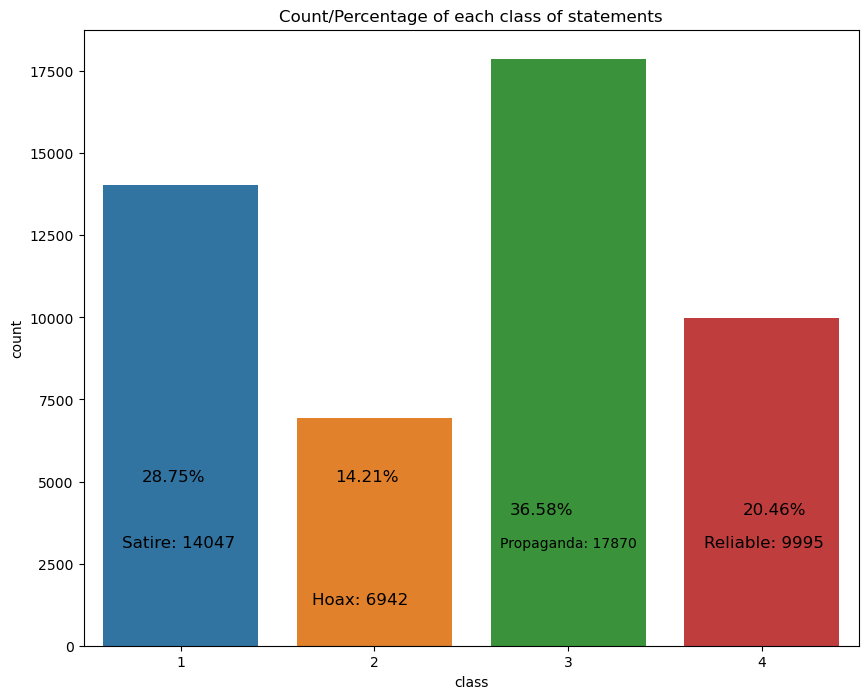

In [21]:
satire_statements = df.loc[df['class'] == 1]
hoax_statements = df.loc[df['class'] == 2]
propaganda_statements = df.loc[df['class'] == 3]
reliable_statements = df.loc[df['class'] == 4]


# Percentage of each class
satire_percent = round(len(satire_statements)/len(df)*100,2)
hoax_percent = round(len(hoax_statements)/len(df)*100,2)
propaganda_percent = round(len(propaganda_statements)/len(df)*100,2)
reliable_percent = round(len(reliable_statements)/len(df)*100,2)




fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(x='class', data=df)
plt.annotate(f'Satire: {len(satire_statements)}', 
             xy=(-0.3, 3000), # xy = (x dist from 0, y dist from 0)
            size=12)

plt.annotate(f'Hoax: {len(hoax_statements)}', 
             xy=(0.68, 1250), # xy = (x dist from 0, y dist from 0)
            size=12)
plt.annotate(f'Propaganda: {len(propaganda_statements)}', 
             xy=(1.65, 3000), # xy = (x dist from 0, y dist from 0)
            size=10)
plt.annotate(f'Reliable: {len(reliable_statements)}', 
             xy=(2.7, 3000), # xy = (x dist from 0, y dist from 0)
            size=12)



plt.annotate(f'{satire_percent}%', xy=(-0.2, 5000),size=12)
plt.annotate(f'{hoax_percent}%', xy=(0.8, 5000),size=12)
plt.annotate(f'{propaganda_percent}%', xy=(1.7, 4000),size=12)
plt.annotate(f'{reliable_percent}%', xy=(2.9, 4000),size=12)


ax.set_title('Count/Percentage of each class of statements')

## From the countplot above, we can see that there is slight class imbalance, whereby 36.58% percent of the training data belongs to label '3' - propaganda and only 14.21% belonging to label '2' - hoax

# Implement Baseline Models

In [22]:
# Make a copy of the original dataframe
df1 = df.copy()

# conver the text column into string
df1['text'] = df1['text'].map(str.lower)

X_train_full = df1['text']
y_train_full = df1['class']

# Specify baseline data train_test_split
- use a baseline 15% test split by default to cross check val loss/f1 score

In [23]:
sentences,labels = get_sentences_and_labels(df1)

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.15, random_state=randomseed)

# Train baseline models based on unprocessed data to get baseline performance

- We use TfidfVectorizer and CountVectorizer as the baseline with ngram_range = (1,1) and max_features = 10000

In [24]:
# specify max_features as 10000, since we have a large corpus
countvec = CountVectorizer(ngram_range=(1,1), max_features = 10000)
tfidfvec = TfidfVectorizer(ngram_range=(1,1), max_features = 10000)


# use tfidf to fit_transform training data
X_train_tfidf = tfidfvec.fit_transform(X_train)

# use tfidf to transform test data
X_test_tfidf = tfidfvec.transform(X_test)

# use tfidf to fit_transform training data
X_train_tfidf_full = tfidfvec.fit_transform(X_train_full)

# use tfidf to transform test data from balancedtest.csv
X_test_tfidf_full = tfidfvec.transform(X_test_full)


# use countvec to fit_transform training data
X_train_countvec = countvec.fit_transform(X_train)

# use countvec to transform test data
X_test_countvec = countvec.transform(X_test)

# use countvec to fit_transform training data
X_train_countvec_full = countvec.fit_transform(X_train_full)

# use countvec to transform test data
X_test_countvec_full = countvec.transform(X_test_full)


# Baseline NB tfidf on val dataset & balancedtest.csv

Test F1-score: 0.886
Test precision: 0.886
              precision    recall  f1-score   support

           1       0.84      0.90      0.87      2171
           2       0.92      0.86      0.89      1002
           3       0.90      0.96      0.93      2630
           4       0.92      0.76      0.83      1526

    accuracy                           0.89      7329
   macro avg       0.90      0.87      0.88      7329
weighted avg       0.89      0.89      0.89      7329



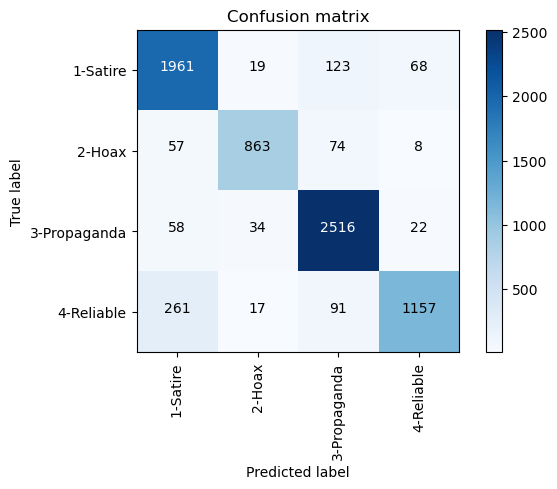

In [25]:
# Train mnb baseline with unprocssed data
mnb = MultinomialNB().fit(X_train_tfidf, y_train)

# score our model using our pre-defined function based on f1 and precision.
mnb_base_dict1 = score_model(mnb, (X_train_tfidf,X_test_tfidf,y_train,y_test))

Test F1-score: 0.686
Test precision: 0.686
              precision    recall  f1-score   support

           1       0.63      0.66      0.64       750
           2       0.68      0.48      0.56       750
           3       0.61      0.90      0.73       750
           4       0.91      0.70      0.79       750

    accuracy                           0.69      3000
   macro avg       0.71      0.69      0.68      3000
weighted avg       0.71      0.69      0.68      3000



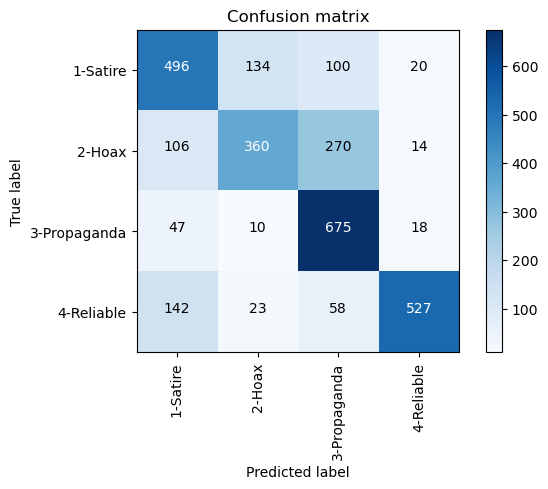

In [26]:
# train NB on full data and check test performance compared with y_ground_truth

# Train mnb baseline with unprocssed data
mnb_full = MultinomialNB().fit(X_train_tfidf_full, y_train_full)

# score our model using our pre-defined function based on f1 and precision.
mnb_base_dict1_full = score_model(mnb_full, (X_train_tfidf_full,X_test_tfidf_full,y_train_full,y_ground_truth))

# Baseline NB countvec on val dataset & balancedtest.csv

Test F1-score: 0.889
Test precision: 0.889
              precision    recall  f1-score   support

           1       0.87      0.88      0.87      2171
           2       0.87      0.92      0.89      1002
           3       0.93      0.92      0.93      2630
           4       0.87      0.82      0.84      1526

    accuracy                           0.89      7329
   macro avg       0.88      0.89      0.88      7329
weighted avg       0.89      0.89      0.89      7329



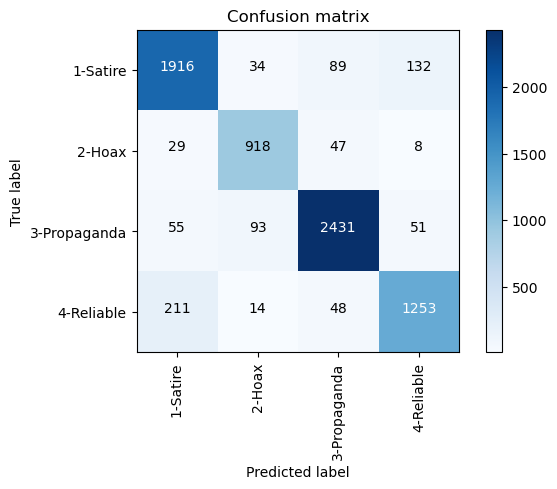

In [27]:
# Train mnb baseline with unprocssed data
mnb = MultinomialNB().fit(X_train_countvec, y_train)

# score our model using our pre-defined function based on f1 and precision.
mnb_base_dict2 = score_model(mnb, (X_train_countvec,X_test_countvec,y_train,y_test))

Test F1-score: 0.713
Test precision: 0.713
              precision    recall  f1-score   support

           1       0.68      0.59      0.64       750
           2       0.66      0.58      0.62       750
           3       0.67      0.86      0.75       750
           4       0.84      0.81      0.83       750

    accuracy                           0.71      3000
   macro avg       0.71      0.71      0.71      3000
weighted avg       0.71      0.71      0.71      3000



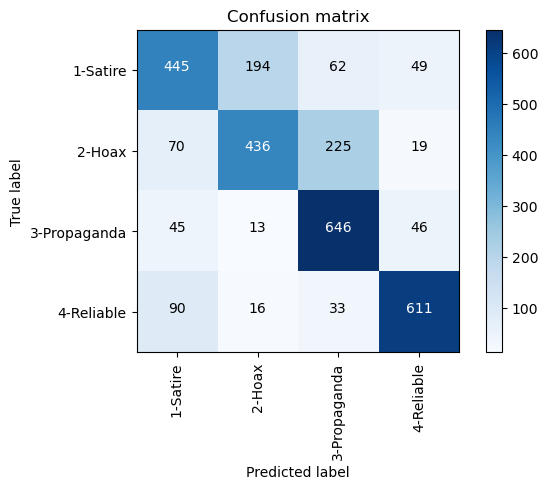

In [28]:
# Train mnb baseline with unprocssed data
mnb_full = MultinomialNB().fit(X_train_countvec_full, y_train_full)

# score our model using our pre-defined function based on f1 and precision.
mnb_base_dict2_full = score_model(mnb_full, (X_train_countvec_full,X_test_countvec_full,y_train_full,y_ground_truth))




# Baseline LR tfidf on val dataset & balancedtest.csv

Test F1-score: 0.962
Test precision: 0.962
              precision    recall  f1-score   support

           1       0.96      0.97      0.96      2171
           2       0.98      0.95      0.97      1002
           3       0.96      0.98      0.97      2630
           4       0.97      0.93      0.95      1526

    accuracy                           0.96      7329
   macro avg       0.97      0.96      0.96      7329
weighted avg       0.96      0.96      0.96      7329



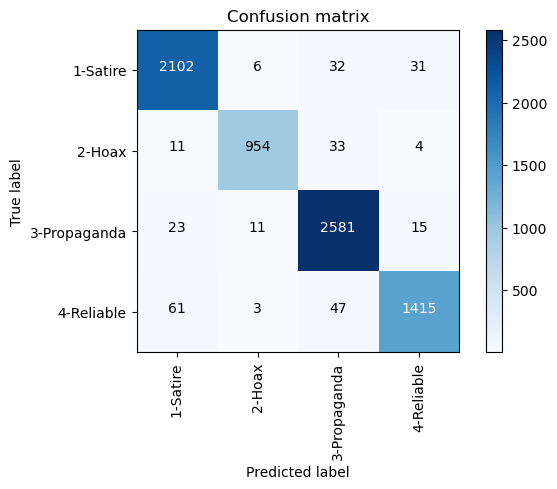

In [29]:
# Train LR baseline with unprocssed data
LR = LogisticRegression(solver='saga').fit(X_train_tfidf, y_train)

# score our model using our pre-defined function based on f1 and precision.
LR_base_dict1 = score_model(LR, (X_train_tfidf,X_test_tfidf,y_train,y_test))

Test F1-score: 0.728
Test precision: 0.728
              precision    recall  f1-score   support

           1       0.84      0.79      0.82       750
           2       0.82      0.38      0.52       750
           3       0.56      0.83      0.67       750
           4       0.81      0.92      0.86       750

    accuracy                           0.73      3000
   macro avg       0.76      0.73      0.72      3000
weighted avg       0.76      0.73      0.72      3000



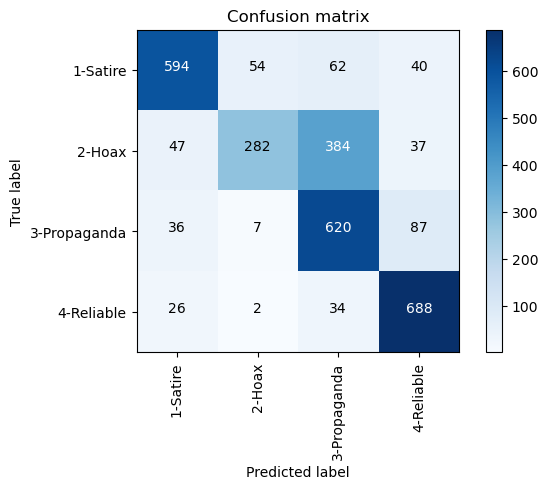

In [30]:
# Train LR baseline with unprocssed data
LR_full = LogisticRegression(solver='saga').fit(X_train_tfidf_full, y_train_full)

# score our model using our pre-defined function based on f1 and precision.
LR_base_dict1_full = score_model(LR_full, (X_train_tfidf_full,X_test_tfidf_full,y_train_full,y_ground_truth))

# Baseline LR countvec on val dataset & balancedtest.csv

C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Test F1-score: 0.634
Test precision: 0.634
              precision    recall  f1-score   support

           1       0.75      0.57      0.64      2171
           2       0.31      0.01      0.02      1002
           3       0.59      0.90      0.71      2630
           4       0.63      0.68      0.66      1526

    accuracy                           0.63      7329
   macro avg       0.57      0.54      0.51      7329
weighted avg       0.61      0.63      0.59      7329



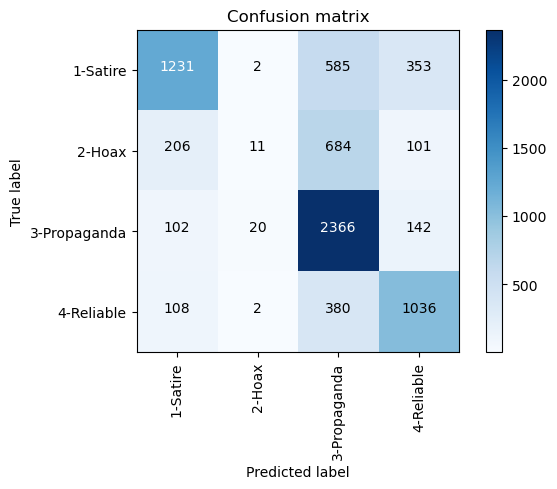

In [31]:
# Train mnb baseline with unprocssed data
LR = LogisticRegression(solver='saga').fit(X_train_countvec, y_train)



# score our model using our pre-defined function based on f1 and precision.
LR_base_dict2 = score_model(LR, (X_train_countvec,X_test_countvec,y_train,y_test))

C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Test F1-score: 0.526
Test precision: 0.526
              precision    recall  f1-score   support

           1       0.72      0.49      0.58       750
           2       0.75      0.00      0.01       750
           3       0.41      0.94      0.57       750
           4       0.66      0.67      0.66       750

    accuracy                           0.53      3000
   macro avg       0.63      0.53      0.46      3000
weighted avg       0.63      0.53      0.46      3000



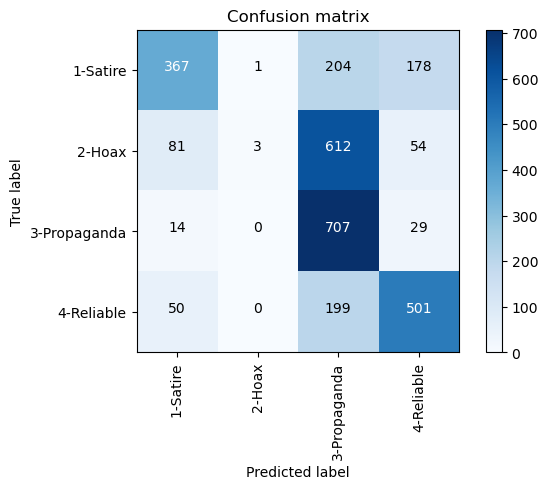

In [32]:
# Train mnb baseline with unprocssed data
LR_full = LogisticRegression(solver='saga').fit(X_train_countvec_full, y_train_full)



# score our model using our pre-defined function based on f1 and precision.
LR_base_dict2_full = score_model(LR_full, (X_train_countvec_full,X_test_countvec_full,y_train_full,y_ground_truth))

# Baseline SVC tfidf on val dataset & balancedtest.csv

Test F1-score: 0.962
Test precision: 0.962
              precision    recall  f1-score   support

           1       0.95      0.97      0.96      2171
           2       0.97      0.96      0.97      1002
           3       0.96      0.98      0.97      2630
           4       0.97      0.91      0.94      1526

    accuracy                           0.96      7329
   macro avg       0.97      0.96      0.96      7329
weighted avg       0.96      0.96      0.96      7329



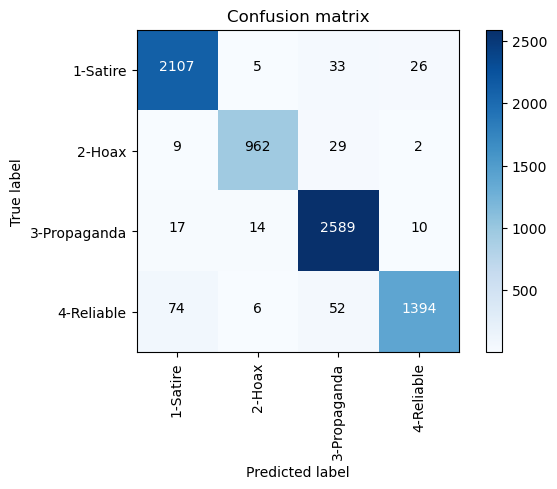

In [33]:
SVC = SGDClassifier(loss='hinge', random_state=randomseed).fit(X_train_tfidf, y_train)

# score our model using our pre-defined function based on f1 and precision.
SVC_base_dict1 = score_model(SVC, (X_train_tfidf,X_test_tfidf,y_train,y_test))

Test F1-score: 0.734
Test precision: 0.734
              precision    recall  f1-score   support

           1       0.85      0.78      0.81       750
           2       0.80      0.40      0.53       750
           3       0.57      0.86      0.69       750
           4       0.83      0.90      0.86       750

    accuracy                           0.73      3000
   macro avg       0.76      0.73      0.72      3000
weighted avg       0.76      0.73      0.72      3000



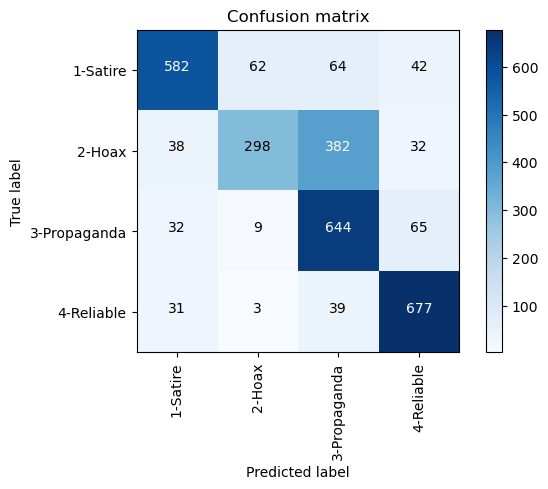

In [34]:
# Train mnb baseline with unprocssed data
# SVC_full = SVC(kernel='linear').fit(X_train_tfidf_full, y_train_full)
SVC_full = SGDClassifier(loss='hinge', random_state=randomseed).fit(X_train_tfidf_full, y_train_full)


# score our model using our pre-defined function based on f1 and precision.
SVC_base_dict1_full = score_model(SVC_full, (X_train_tfidf_full,X_test_tfidf_full,y_train_full,y_ground_truth))

# Baseline SVC countvec on val dataset & balancedtest.csv

Test F1-score: 0.782
Test precision: 0.782
              precision    recall  f1-score   support

           1       0.98      0.61      0.75      2171
           2       0.92      0.92      0.92      1002
           3       0.98      0.75      0.85      2630
           4       0.51      0.99      0.67      1526

    accuracy                           0.78      7329
   macro avg       0.85      0.82      0.80      7329
weighted avg       0.87      0.78      0.79      7329



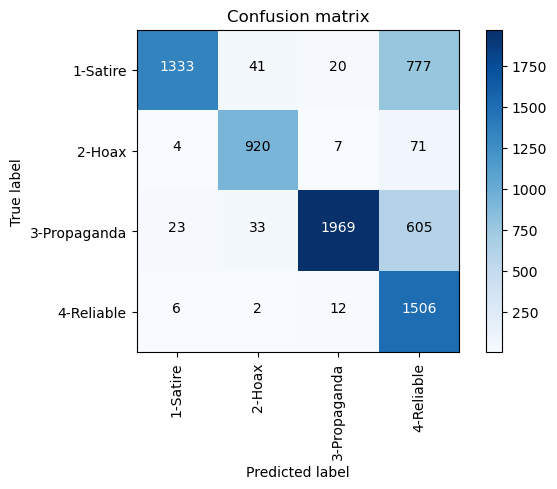

In [35]:
# Train mnb baseline with unprocssed data
SVC = SGDClassifier(loss='hinge', random_state=randomseed).fit(X_train_tfidf, y_train)

# score our model using our pre-defined function based on f1 and precision.
SVC_base_dict2 = score_model(SVC, (X_train_countvec,X_test_countvec,y_train,y_test))

Test F1-score: 0.683
Test precision: 0.683
              precision    recall  f1-score   support

           1       0.76      0.81      0.79       750
           2       0.77      0.29      0.43       750
           3       0.52      0.71      0.60       750
           4       0.78      0.91      0.84       750

    accuracy                           0.68      3000
   macro avg       0.71      0.68      0.66      3000
weighted avg       0.71      0.68      0.66      3000



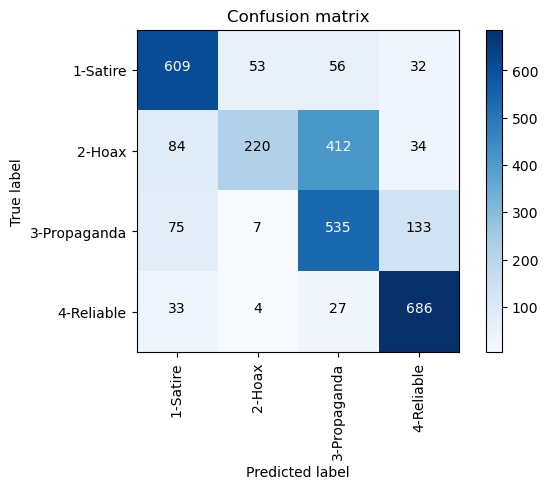

In [36]:
# Train mnb baseline with unprocssed data
SVC_full = SGDClassifier(loss='hinge', random_state=randomseed).fit(X_train_countvec_full, y_train_full)

# score our model using our pre-defined function based on f1 and precision.
SVC_base_dict2_full = score_model(SVC_full, (X_train_countvec_full,X_test_countvec_full,y_train_full,y_ground_truth))

# Summary of results for balancedtest.csv:

We observed the following performances for NB and LR using tfidf/countvectorizer - ngram_range(1,1) and max_features = 10000:
- NB tfidf - 0.686
- NB countvec - 0.713
- LR tfidf - 0.728
- LR countvec - 0.526
- **SVC tfidf - 0.734 (Best Model on base dataset)**
- SVC countvec - 0.683

### Our simplest baseline without any data preprocessing happens to be for SVC tfidf , with a f1_score (average='micro') of 0.734

### Let us see how data preprocessing may help with data performance

# Data Preprocessing
- check for duplicate data and remove duplicate data to prevent overfitting
- removal of stopwords, punctuations and NLTK word lemmatization with POS tag considerations
- adding text subjectivity and sentiment


In [37]:
# Define a function that takes in a dataframe and removes duplicates and also handles contradicting statements.
# performs case folding, followed by removing exact duplicates and contradicting data

# to be performed only for training data to improve quality of training dataset.
def casefold_and_remove_duplicates_and_contradicts(df):
    # Store a copy of the original df to be used later.
    df_original = df.copy()
    
    # first convert our Text column from object to string
    df['text'] = df['text'].astype('string')
    df_original['text'] = df_original['text'].astype('string')
    # Do case folding by using map & lower function
    df['text']=df['text'].map(str.lower)
    df_original['text']=df_original['text'].map(str.lower)
    
    ################################### START TO HANDLE DATA W/ CONTRADICTING LABEL ##########################
    
    # Start to remove exact duplicates where text and label are the same, as it could lead to overfitting.
    df2 = df.groupby(['text', 'class']).size().reset_index(name='counts')
    df2 = df2.sort_values('counts',ascending=False)
    
    # Remove contradicting labels for the same statement
    contradicting_label_text_df = df2.loc[df2['text'].duplicated(),:]
    # for all text data that we see in contradicting_label_text_df,
    # decide how to fix the labels for such data, since there are only 7 of such occurrences
    all_contradicting_label_text_df = pd.DataFrame()

    for index,row in contradicting_label_text_df.iterrows():
        df_to_append = df_original.loc[df_original.Text == row['text']]
        all_contradicting_label_text_df = pd.concat([all_contradicting_label_text_df, df_to_append])
        
    # pad the observations to the minority. In addition, this will also result in help in the data imbalance.
    index_to_update_verdict = [] # store all the indexes to be updated for verdict in training data set
    
    for index, row in contradicting_label_text_df.iterrows():
        # print(row['Text'])
        # print(df.loc[df['Text'] == row['Text']].index)
        index_to_update_verdict.extend(df_original.loc[df_original['text'] == row['text']].index)

    # Loop through the indexes to update the verdict column for these indexes in df_original
    for index in index_to_update_verdict:
        df_original.loc[df_original.index == index, ['class']] = 0
    
    ################################### END OF HANDLING DATA W/ CONTRADICTING LABEL ##########################
    
    ################################### START TO HANDLE DUPLICATED DATA ##########################
    # After handling data with contradicting label, find the new df2 to remove duplicates again
    new_df = df_original.drop_duplicates(keep='first', subset=['text'])
    
    # return the preprocessed new_df
    return new_df
    
    


# Remove duplicates from training data

In [38]:
# get new df with casefolding and duplicates removed
new_df1 = casefold_and_remove_duplicates_and_contradicts(df1)

In [39]:
# get stopwords list from spacy
en = spacy.load('en_core_web_sm')

sw_spacy = en.Defaults.stop_words

# initialize our lemmatizer for usage in our subsequent function
lemmatizer = WordNetLemmatizer()

# Get all punctuations
punctuations = string.punctuation
# Store all punctuations as a list
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”", "``", "''"]

C:\Users\Gary2\anaconda3\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [40]:
# Version 2, remove punctuations, lemmatize with POS tag, and removes stopwords
# Lemmatizer will use a part-of-speech (POS) tag - as some words such as decriminalizing still remained the same.
# Define a part of speech tagger
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ #adjective
    elif nltk_tag.startswith('V'):
        return wordnet.VERB # verb
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN # noun
    elif nltk_tag.startswith('R'):
        return wordnet.ADV #
    else:         
        return None

def lemmatizePOS_and_remove_stopwords_and_punctuations_add_subjectivity_sentiment(df, colname):
    df_copy = df.copy() # make edits on df_copy instead of df
    for index,row in df.iterrows():
        # Split the sentence into words using word_tokenize
        word_list = nltk.word_tokenize(row[colname])
        
        # First check if each word belongs in the spacy's stopwod list, else emove it
        # list comprehension, only keep the word that is not present in the sw_spacy list & remove punctuations in one step
        word_list_remove_sw_and_punc = [token for token in word_list if token.lower() not in sw_spacy and token.lower() not in SYMBOLS]
        
#         # Remove all punctuations
#         word_list_remove_punctuations = [token for token in word_list_remove_sw if token.lower() not in SYMBOLS]
        
        # With the current word list without stopwords and punctuations, find the POS tag for each token.
        # loop through the list and find POS tags, to get a list of tuples
        word_list_POS_tagged = nltk.pos_tag(word_list_remove_sw_and_punc)
        
        # use our own pos_tagger function to make things simpler to understand.
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), word_list_POS_tagged))
        
        # initialize our lemmatized sentence
        lemmatized_sentence = []
        
        # Loop through our tagged wordnet list
        for word, tag in wordnet_tagged:
            if tag is None:
                # if there is no available tag, append the token as is
                lemmatized_sentence.append(word)
            else:
                # else use the POS tag to lemmatize the token
                lemmatized_sentence.append(lemmatizer.lemmatize(word,tag))
                
        # Get our lemmatized sentence
        lemmatized_sentence = " ".join(lemmatized_sentence)
        
        
        #### Feature Engineering #####
        # Compute sentiment polarity and subjectivity
        text_blob = TextBlob(lemmatized_sentence)
        sentiment = text_blob.sentiment.polarity
        subjectivity = text_blob.sentiment.subjectivity

        # Add sentiment polarity and subjectivity to the dataframe
        df_copy.loc[df_copy.index == index, 'sentiment'] = sentiment
        df_copy.loc[df_copy.index == index, 'subjectivity'] = subjectivity
        
        # fix the output of each text with the new lemmatized and no stopwords text.
        df_copy.loc[df_copy.index == index, [colname]] = lemmatized_sentence
        
    return df_copy

## Carry out lemmatization, stopwords and punctuations removal for new_df1 dataframe to get new_df3 dataframe

In [41]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

new_df3 = new_df1.copy() # Copy over from previous whereby we removed duplicates and performed casefolding

new_df3 = lemmatizePOS_and_remove_stopwords_and_punctuations_add_subjectivity_sentiment(new_df3, 'text')

new_df3.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gary2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Gary2\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gary2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,class,text,sentiment,subjectivity
0,1,little decade ago hockey fan bless slate game ...,0.167250,0.579000
1,1,writer hbo series soprano take dare storytelli...,0.250758,0.538636
2,1,despite claim tv news outlet offer 'nonstop ne...,0.080076,0.412470
3,1,receive 'subpar service experience unusually l...,0.118183,0.404162
4,1,watch beloved seattle mariner prevail san dieg...,0.194918,0.593101


In [42]:
# do the same operation for the test dataset

# to be performed only for training data to improve quality of training dataset.
def casefold(df):
    # Store a copy of the original df to be used later.
    df_original = df.copy()
    
    # first convert our Text column from object to string
    df['text'] = df['text'].astype('string')
    df_original['text'] = df_original['text'].astype('string')
    # Do case folding by using map & lower function
    df['text']=df['text'].map(str.lower)
    df_original['text']=df_original['text'].map(str.lower)
    return df_original

    
test_df3 = casefold(test_df)

test_df3 = lemmatizePOS_and_remove_stopwords_and_punctuations_add_subjectivity_sentiment(test_df3, 'text')


In [43]:
test_df3.head()

,class,text,sentiment,subjectivity
0,1,actor content churn performance quick paycheck...,0.089250,0.551573
1,1,football insider call unexpectedly severe puni...,0.052525,0.565825
2,1,freak accident follow game 3 n.b.a final cleve...,-0.117045,0.513636
3,1,north korea official news agency announce toda...,0.003977,0.426452
4,1,alaska governor sarah palin bring much-needed ...,0.101420,0.471054


# Feature Engineering

### Define new variables for text subjectivity and text sentiment for each statement, after performing the preprocessing, and check performance on baseline models

For the statement classification task you described, it's important to consider the characteristics of each class. Here's a brief analysis:

- Satire: This type of statement typically involves humor, irony, or exaggeration. It may not have a clear polarity since the underlying sentiment can be subtle or mixed.
- Hoax: A hoax is a false statement or piece of information meant to deceive. The text polarity might not be a strong indicator here, as the content may appear positive, negative, or neutral.
- Propaganda: Propaganda often has a persuasive intention, which may include emotional appeals. Sentiment and subjectivity could play a role in identifying propaganda, as it might have a distinct polarity or subjective nature.
- Reliable: Reliable statements are expected to be factual and objective. They might exhibit low subjectivity and could have varying degrees of polarity depending on the topic.

How might additional features be helpful?

- Text Subjectivity: The subjectivity of the text might be a more informative feature for distinguishing between reliable, factual information and more opinionated or biased statements, such as propaganda.
- Text Sentiment: Sentiment (positive, negative, or neutral) could provide additional information to help separate propaganda or satire from reliable information. However, it might be less informative for distinguishing between different types of unreliable statements, such as satire and hoax.



## Due to memory constraints, the addtional features will only be trialed on transformer models instead of combining together with TfidfVectorizer & CountVectorizer

# Check our results of removing duplicates/stopword & punctuations rmoval/lemmatization w/ POS tags on balancedtest.csv

In [87]:
# training data after preprocessing
X_train_full3 = new_df3['text']
y_train_full3 = new_df3['class']

# test data after preprocessing
y_ground_truth3 = test_df3['class']
X_test_full3 = test_df3['text']


# tfidf transform
X_train_tfidf_full = tfidfvec.fit_transform(X_train_full3)
X_test_tfidf_full = tfidfvec.transform(X_test_full3)

# countvec transform
X_train_countvec_full = countvec.fit_transform(X_train_full3)
X_test_countvec_full = countvec.transform(X_test_full3)

# NB tfidf after preprocessing on balancedtest.csv

Test F1-score: 0.672
Test precision: 0.672
              precision    recall  f1-score   support

           1       0.60      0.59      0.60       750
           2       0.65      0.51      0.57       750
           3       0.61      0.90      0.73       750
           4       0.91      0.68      0.78       750

    accuracy                           0.67      3000
   macro avg       0.69      0.67      0.67      3000
weighted avg       0.69      0.67      0.67      3000



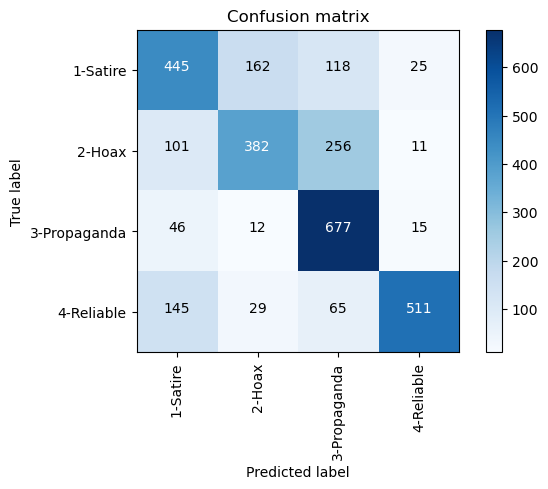

In [45]:
# Train mnb baseline with unprocssed data
mnb_full = MultinomialNB().fit(X_train_tfidf_full, y_train_full3)

# use tfidf to transform test data from balancedtest.csv
X_test_tfidf_full = tfidfvec.transform(X_test_full3)

# score our model using our pre-defined function based on f1 and precision.
mnb_base_dict1_full = score_model(mnb_full, (X_train_tfidf_full,X_test_tfidf_full,y_train_full3,y_ground_truth3))


# NB countvec after preprocessing on balancedtes.csv

Test F1-score: 0.704
Test precision: 0.704
              precision    recall  f1-score   support

           1       0.64      0.53      0.58       750
           2       0.63      0.63      0.63       750
           3       0.69      0.87      0.77       750
           4       0.87      0.79      0.82       750

    accuracy                           0.70      3000
   macro avg       0.71      0.70      0.70      3000
weighted avg       0.71      0.70      0.70      3000



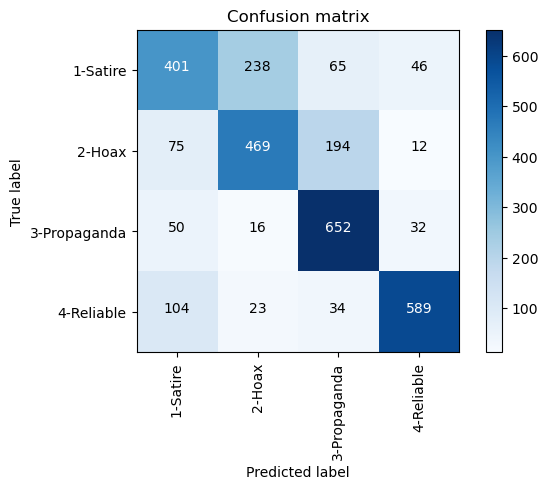

In [46]:
# Train mnb baseline with unprocssed data
mnb_full = MultinomialNB().fit(X_train_countvec_full, y_train_full3)

# score our model using our pre-defined function based on f1 and precision.
mnb_base_dict2_full = score_model(mnb_full, (X_train_countvec_full,X_test_countvec_full,y_train_full3,y_ground_truth3))


# LR tfidf after preprocessing on balancedtest.csv

Test F1-score: 0.744
Test precision: 0.744
              precision    recall  f1-score   support

           1       0.82      0.76      0.79       750
           2       0.79      0.46      0.58       750
           3       0.61      0.86      0.71       750
           4       0.83      0.89      0.86       750

    accuracy                           0.74      3000
   macro avg       0.76      0.74      0.74      3000
weighted avg       0.76      0.74      0.74      3000



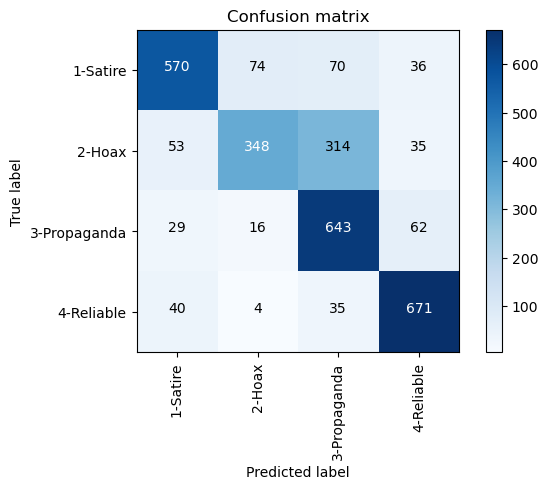

In [47]:
# Train mnb baseline with unprocssed data
LR_full = LogisticRegression(solver='saga').fit(X_train_tfidf_full, y_train_full3)


# score our model using our pre-defined function based on f1 and precision.
LR_base_dict2_full = score_model(LR_full, (X_train_tfidf_full,X_test_tfidf_full,y_train_full3,y_ground_truth3))


# LR countvec after preprocessing on balancedtest.csv

Test F1-score: 0.617
Test precision: 0.617
              precision    recall  f1-score   support

           1       0.65      0.61      0.63       750
           2       0.72      0.19      0.30       750
           3       0.53      0.89      0.66       750
           4       0.70      0.78      0.74       750

    accuracy                           0.62      3000
   macro avg       0.65      0.62      0.58      3000
weighted avg       0.65      0.62      0.58      3000



C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


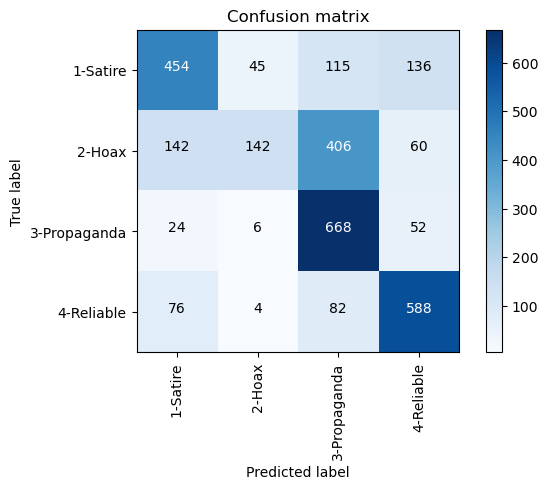

In [48]:
# Train mnb baseline with unprocssed data
LR_full = LogisticRegression(solver='saga').fit(X_train_countvec_full, y_train_full3)

# score our model using our pre-defined function based on f1 and precision.
LR_base_dict2_full = score_model(LR_full, (X_train_countvec_full,X_test_countvec_full,y_train_full3,y_ground_truth3))


# SVC tfidf after preprocessing on balancedtest.csv

Test F1-score: 0.738
Test precision: 0.738
              precision    recall  f1-score   support

           1       0.81      0.73      0.77       750
           2       0.77      0.47      0.58       750
           3       0.61      0.87      0.71       750
           4       0.84      0.88      0.86       750

    accuracy                           0.74      3000
   macro avg       0.76      0.74      0.73      3000
weighted avg       0.76      0.74      0.73      3000



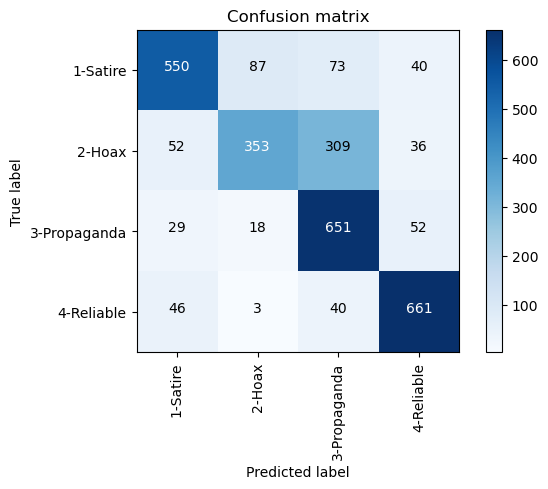

In [89]:
# Train mnb baseline with unprocssed data
SVC_full = SGDClassifier(loss='hinge', random_state=randomseed).fit(X_train_tfidf_full, y_train_full3)


# score our model using our pre-defined function based on f1 and precision.
SVC_base_dict2_full = score_model(SVC_full, (X_train_tfidf_full,X_test_tfidf_full,y_train_full3,y_ground_truth3))


# SVC countvec after preprocssing on balancedtest.csv

Test F1-score: 0.683
Test precision: 0.683
              precision    recall  f1-score   support

           1       0.77      0.73      0.75       750
           2       0.73      0.34      0.47       750
           3       0.53      0.77      0.63       750
           4       0.79      0.89      0.84       750

    accuracy                           0.68      3000
   macro avg       0.71      0.68      0.67      3000
weighted avg       0.71      0.68      0.67      3000



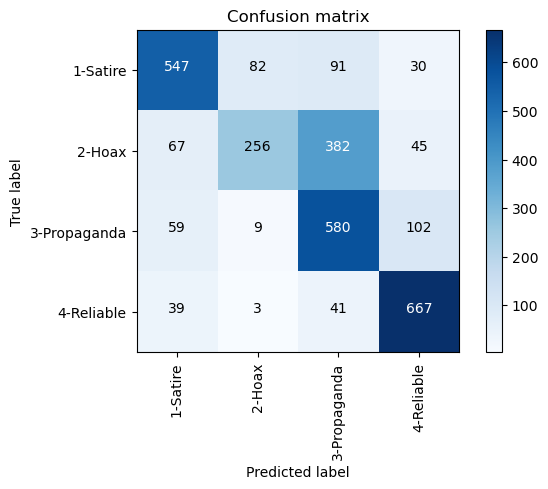

In [90]:
# Train mnb baseline with unprocssed data
SVC_full = SGDClassifier(loss='hinge', random_state=randomseed).fit(X_train_countvec_full, y_train_full3)


# score our model using our pre-defined function based on f1 and precision.
SVC_base_dict2_full = score_model(SVC_full, (X_train_countvec_full,X_test_countvec_full,y_train_full3,y_ground_truth3))


# Summary of results for balancedtest.csv after removing duplicates/stopwords/punctuations/lemmatization w/POS tags:

We observed the following performances for NB and LR using tfidf/countvectorizer - ngram_range(1,1):
- NB tfidf - 0.672
- NB countvec - 0.704
- **LR tfidf - 0.748 - best model after preprocessing**
- LR countvec - 0.618
- SVC tfidf - 0.738
- SVC countvec - 0.683


### Removal of duplicates, casefolding, lemmatization w/ POS tag consideration, stopwords&punctuations removal and resulted in a 0.014 increase in f1_score (average='micro') of 0.744 from 0.730 for our best model

### Hence, preprocessing has been working so far, as there was a total of ~1.4% increase in micro f1_score

### Best model so far: LR (tfidf) w/ score of 0.744

# Try to make use of text subjectivity and sentiment to improve the scores by concatenating the features together

In [91]:
# training data after preprocessing
X_train_full3 = new_df3['text']
y_train_full3 = new_df3['class']

# test data after preprocessing
y_ground_truth3 = test_df3['class']
X_test_full3 = test_df3['text']


# tfidf transform
X_train_tfidf_full = tfidfvec.fit_transform(X_train_full3)
X_test_tfidf_full = tfidfvec.transform(X_test_full3)

# countvec transform
X_train_countvec_full = countvec.fit_transform(X_train_full3)
X_test_countvec_full = countvec.transform(X_test_full3)

In [92]:
# training & test data from tfidf
X_tfidf_df = pd.DataFrame(X_train_tfidf_full.toarray())
X_test_tfidf_df = pd.DataFrame(X_test_tfidf_full.toarray())

# training & test data from countvec
X_countvec_df = pd.DataFrame(X_train_countvec_full.toarray())
X_test_countvec_df = pd.DataFrame(X_test_countvec_full.toarray())


# noramlize sentiment and subjectivity scores from data
scaler = MinMaxScaler()
normalized_scores = scaler.fit_transform(new_df3[['sentiment', 'subjectivity']])
normalized_scores_df = pd.DataFrame(normalized_scores, columns=['sentiment', 'subjectivity'])

normalized_scores_test = scaler.transform(test_df3[['sentiment', 'subjectivity']])
normalized_scores_test_df = pd.DataFrame(normalized_scores_test, columns=['sentiment','subjectivity'])

# Concatenate the DataFrames with subjectivity and sentiment data
X_combined_tfidf = pd.concat([X_tfidf_df, normalized_scores_df], axis=1) # tfidf combined
X_combined_countvec = pd.concat([X_countvec_df, normalized_scores_df], axis=1) # countvec combined

X_combined_test_tfidf = pd.concat([X_test_tfidf_df, normalized_scores_test_df], axis=1) # tfidf combined
X_combined_test_countvec = pd.concat([X_test_countvec_df, normalized_scores_test_df], axis=1) # countvec combined

# NB tfidf + subjectivity + sentiment on balancedtest.csv

C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Test F1-score: 0.678
Test precision: 0.678
              precision    recall  f1-score   support

           1       0.61      0.61      0.61       750
           2       0.65      0.51      0.58       750
           3       0.62      0.90      0.73       750
           4       0.91      0.69      0.78       750

    accuracy                           0.68      3000
   macro avg       0.70      0.68      0.67      3000
weighted avg       0.70      0.68      0.67      3000



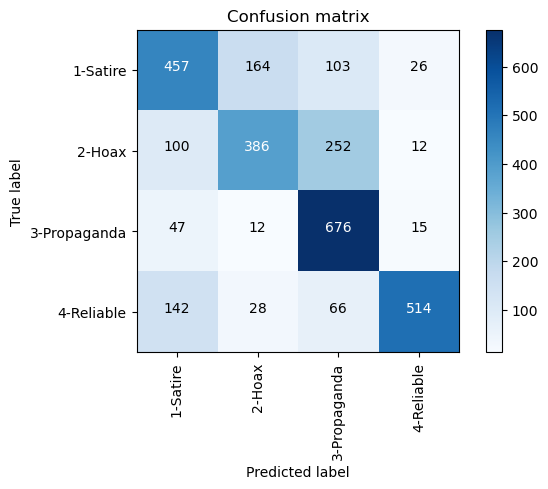

In [53]:
# fit mnb model
mnb_full = MultinomialNB().fit(X_combined_tfidf, y_train_full3)

# score our model using our pre-defined function based on f1 and precision.
mnb_base_dict3_full = score_model(mnb_full, (X_combined_tfidf,X_combined_test_tfidf,y_train_full3,y_ground_truth3))


# NB countvec + subjectivity + sentiment on balancedtest.csv

C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Test F1-score: 0.706
Test precision: 0.706
              precision    recall  f1-score   support

           1       0.64      0.54      0.58       750
           2       0.63      0.63      0.63       750
           3       0.70      0.87      0.77       750
           4       0.87      0.79      0.83       750

    accuracy                           0.71      3000
   macro avg       0.71      0.71      0.70      3000
weighted avg       0.71      0.71      0.70      3000



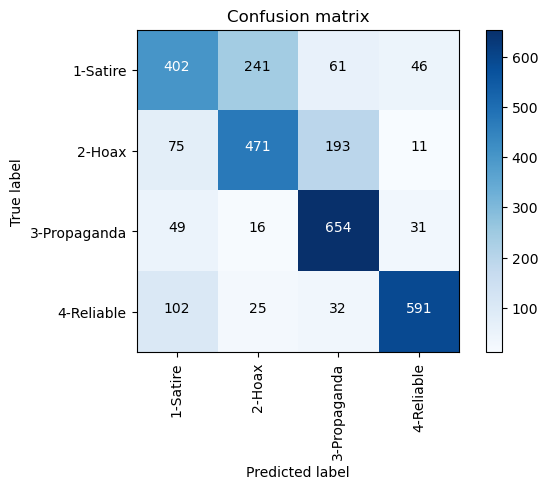

In [54]:
# fit mnb model
mnb_full = MultinomialNB().fit(X_combined_countvec, y_train_full3)

# score our model using our pre-defined function based on f1 and precision.
mnb_base_dict3_full = score_model(mnb_full, (X_combined_countvec,X_combined_test_countvec,y_train_full3,y_ground_truth3))


# LR tfidf + subjectivity + sentiment on balancedtest.csv

C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Test F1-score: 0.747
Test precision: 0.747
              precision    recall  f1-score   support

           1       0.83      0.78      0.80       750
           2       0.79      0.46      0.58       750
           3       0.61      0.86      0.72       750
           4       0.83      0.90      0.86       750

    accuracy                           0.75      3000
   macro avg       0.76      0.75      0.74      3000
weighted avg       0.76      0.75      0.74      3000



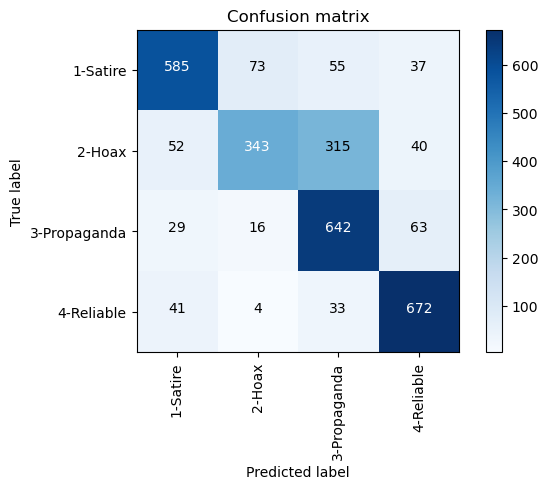

In [55]:
# fit LR model
LR_full = LogisticRegression(solver='saga').fit(X_combined_tfidf, y_train_full3)

# score our model using our pre-defined function based on f1 and precision.
LR_base_dict3_full = score_model(LR_full, (X_combined_tfidf,X_combined_test_tfidf,y_train_full3,y_ground_truth3))


# LR countvec + subjectivity + sentiment on balancedtest.csv

C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Test F1-score: 0.635
Test precision: 0.635
              precision    recall  f1-score   support

           1       0.62      0.73      0.67       750
           2       0.72      0.18      0.29       750
           3       0.55      0.89      0.68       750
           4       0.79      0.73      0.76       750

    accuracy                           0.64      3000
   macro avg       0.67      0.64      0.60      3000
weighted avg       0.67      0.64      0.60      3000



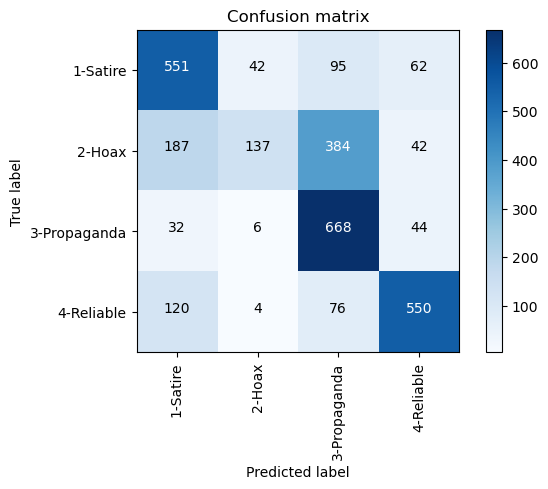

In [56]:
# fit LR model
LR_full = LogisticRegression(solver='saga').fit(X_combined_countvec, y_train_full3)

# score our model using our pre-defined function based on f1 and precision.
LR_base_dict3_full = score_model(LR_full, (X_combined_countvec,X_combined_test_countvec,y_train_full3,y_ground_truth3))


# SVC tfidf + subjectivity + sentiment on balancedtest.csv

C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Test F1-score: 0.748
Test precision: 0.748
              precision    recall  f1-score   support

           1       0.83      0.75      0.79       750
           2       0.77      0.48      0.60       750
           3       0.62      0.87      0.72       750
           4       0.83      0.89      0.86       750

    accuracy                           0.75      3000
   macro avg       0.76      0.75      0.74      3000
weighted avg       0.76      0.75      0.74      3000



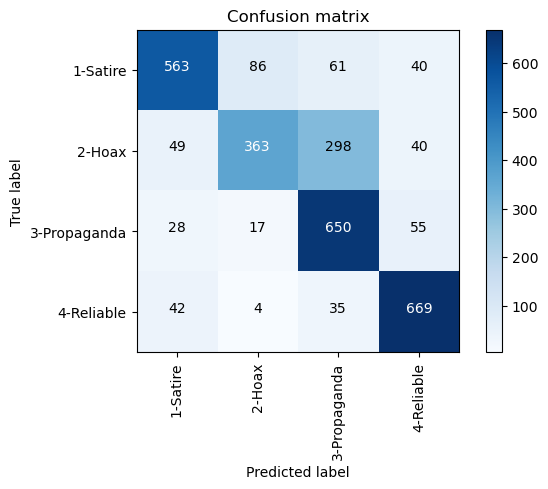

In [93]:
# fit SVC model
SVC_full = SGDClassifier(loss='hinge', random_state=randomseed).fit(X_combined_tfidf, y_train_full3)

# score our model using our pre-defined function based on f1 and precision.
SVC_base_dict3_full = score_model(SVC_full, (X_combined_tfidf,X_combined_test_tfidf,y_train_full3,y_ground_truth3))




# SVC countvec + subjectivity + sentiment on balancedtest.csv

C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Test F1-score: 0.709
Test precision: 0.709
              precision    recall  f1-score   support

           1       0.76      0.71      0.73       750
           2       0.70      0.44      0.54       750
           3       0.59      0.78      0.67       750
           4       0.81      0.91      0.86       750

    accuracy                           0.71      3000
   macro avg       0.72      0.71      0.70      3000
weighted avg       0.72      0.71      0.70      3000



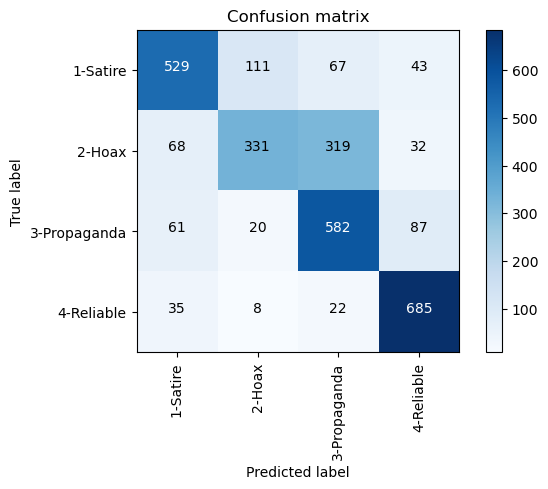

In [77]:
# fit SVC model
SVC_full = SGDClassifier(loss='hinge', random_state=randomseed).fit(X_combined_countvec, y_train_full3)

# score our model using our pre-defined function based on f1 and precision.
SVC_base_dict3_full = score_model(SVC_full, (X_combined_countvec,X_combined_test_countvec,y_train_full3,y_ground_truth3))


# Summary of results for balancedtest.csv after removing duplicates/stopwords/punctuations/lemmatization w/POS tags and feature engineering w/ subjectivity + sentiment:

We observed improvements in performances across the board when the new features are added together with baseline tfidf and countvec features as shown below:
- NB tfidf - 0.678
- NB countvec - 0.706
- LR tfidf - 0.747
- LR countvec - 0.635
- **SVC tfidf - 0.748 - best model**
- SVC countvec - 0.709


### Removal of duplicates, casefolding, lemmatization w/ POS tag consideration, stopwords&punctuations removal and resulted in a 0.004 increase in f1_score (average='micro') of 0.748 from 0.744 for our best model

### Hence, preprocessing has been working so far, as there was a total of ~0.4% increase in micro f1_score

### Best model so far: SVC (tfidf) w/ score of 0.748

# Now let us check whether using data augmentation on the original dataset and running preprocessing techniques there after will help

- technique utilized is round trip translation.
- we sample 5% of the data points in classes 2 and 4 and translate them using a pretrained tokenizer which translates from english -> french -> english, so that we may augment new data points and add these new data points into our training set, so that we can evaluate the performance on the new dataset with that has taken measures to address data imbalance



# Perform summarization of text for our data first, and see whether our result will stay the same if we used the summarized text daa

In [59]:
# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the English-French and French-English translation models
en_to_fr_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
en_to_fr_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
en_to_fr_model.to(device)  # Move the model to GPU

fr_to_en_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-fr-en")
fr_to_en_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-fr-en")
fr_to_en_model.to(device)  # Move the model to GPU

t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-base")
t5_model.to(device)  # Move the model to GPU



def summarize_text(text, model_name="t5-base", max_length=512):
    
    # Prepend "summarize: " to the text, as T5 model expects it for summarization tasks
    input_text = "summarize: " + text

    # Encode the text and generate summary
    input_ids = t5_tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=512).to(device)
    summary_ids = t5_model.generate(input_ids, num_beams=4, no_repeat_ngram_size=2, min_length=30, max_length=max_length, early_stopping=True)
    
    # Decode the summary and return
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


def round_trip_translation(text, max_input_length=512):
    # Count the tokens in the text using the T5 tokenizer
    
    token_count = len(t5_tokenizer.tokenize(text))
    print(token_count)

    # Summarize the text if it's too long
    if token_count > max_input_length:
        text = summarize_text(text, max_length=max_input_length)
        print(text)
        print(len(t5_tokenizer.tokenize(text)))
        
    # Translate English to French
    fr_tokens = en_to_fr_tokenizer.encode(text, return_tensors="pt").to(device)
    fr_translation = en_to_fr_model.generate(fr_tokens)
    fr_text = en_to_fr_tokenizer.decode(fr_translation[0], skip_special_tokens=True)

    # Translate French back to English
    en_tokens = fr_to_en_tokenizer.encode(fr_text, return_tensors="pt").to(device)
    en_translation = fr_to_en_model.generate(en_tokens)
    en_text = fr_to_en_tokenizer.decode(en_translation[0], skip_special_tokens=True)

    return en_text


# Function to select and modify samples for a given class
def process_class(data, class_num):
    selected_class_data = data.loc[data["class"] == class_num]
    selected_samples = selected_class_data.sample(frac=0.05, random_state=1).reset_index(drop=True)
    modified_samples = selected_samples.copy()
    modified_samples["text"] = modified_samples["text"].apply(round_trip_translation)
    
    print(f"Class {class_num} - Original samples:")
    print(selected_samples.head(3))
    print(f"Class {class_num} - Modified samples:")
    print(modified_samples.head(3))
    
    return pd.concat([selected_class_data, modified_samples], ignore_index=True)

C:\Users\Gary2\anaconda3\lib\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
C:\Users\Gary2\anaconda3\lib\site-packages\transformers\models\t5\tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [60]:
# Find the number of data points per class before data augmentation
class_counts = df["class"].value_counts()

print(class_counts)

class_2_df = process_class(df,2)
class_4_df = process_class(df,4)

# Combine the original and modified samples from classes 2 and 4 with the samples from the other classes
other_classes_df = df.loc[~df["class"].isin([2, 4])]
new_df = pd.concat([other_classes_df, class_2_df, class_4_df], ignore_index=True)

new_class_counts = new_df["class"].value_counts()

print(new_class_counts)





3    17870
1    14047
4     9995
2     6942
Name: class, dtype: int64
243


C:\Users\Gary2\anaconda3\lib\site-packages\transformers\generation\utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


301
319
277
386
118
143
259
380
229
260
161
248
365
352
311
203
314
196
389
142
331
163
236
95
83
276
356
233
368
202
186
201
276
276
318
321
236
287
333
225
291
389
191
230
258
286
346
384
263
190
236
355
181
236
280
414
774
the conservative action fund is calling on NBC to fire al Sharpton. john avlon: if he doesn't fire him, the show sponsors will have no choice but to cut ties with the thug. we will call on every liberty loving american to boycott all of the sponsors of Sharptons show.
71
165
333
272
251
168
223
175
161
310
237
17
276
224
210
277
104
250
234
64
367
265
323
302
315
181
144
164
359
240
227
291
247
222
297
351
248
124
151
225
168
226
126
211
123
249
134
178
449
242
307
171
215
622
a gun store filed an accusation with the Bureau of Alcohol, Tobacco, Firearms and Explosives. john sutter: specdive tactical is under fire for buying an AR-15 for illegal purposes. the gun was purchased in 38 minutes, but the report did not mention the fact that producer Paula Reid had told 

C:\Users\Gary2\anaconda3\lib\site-packages\transformers\generation\utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


631
world no. 1 Tiger woods starts the day five shots off the lead at the us open. the 14-time major champion teed off on 10 and recorded his first birdie of the tournament in 74 at pebble beach golf links in florida on thursday morning. american Shaun Micheel and graeme McDowell also start on the back nine, but are two-under through the turn.
93
510
769
'he didn't believe in dumbing down,' the president told a packed hall at Lincoln Center. he also bemoaned the proliferation of instant commentary and celebrity gossip and the softer stories that Walter disdained, rather than the hard news and investigative journalism that Cronkite championed - and that has real consequences in our own lives and in the life of our nation'
87
1398
president Barack Obama appears intent on pursuing the second approach: escalation in Afghanistan. he seeks to 'finish the job' that Bush began there, then all but abandoned, says john avlon jr.
52
518
julian zelizer: the two races are the only big-ticket politi

300
690
GM's board forced Fritz Henderson to resign as chief executive and replaced him with Edward E. Whitacre Jr. a newly approved chemotherapy drug, Folotyn, will cost about $30,000 per month.
46
49
384
415
202
123
876
'Shrek Forever After' wanders far, far away from the infectious and propulsive zing that we've come to expect over the past nine years. instead, it thrusts our hero into a gloomy-tunes alternate universe where Rumpelstiltskin is an ogre-oppressing despot and Fiona (Cameron Diaz) won't give him the time of day.
100
213
265
433
1272
barely one-third of seniors support a health-care overhaul, several polls have found. 'people have gotten more and more worried,' said one mailing from the 60 plus association, which bills itself as conservative alternative to AARP. the legislation trims $563 billion out of Medicare's growth rate over the next 10 years while pumping in about $320 billion.
80
1402
brides wedding genius, iWedding Deluxe and Wedding Plan-It will be introduced o

556
the soft-spoken 61-year-old advocated for the insurance industry when it was under fierce political attack. as he stepped down as Aetna's chief executive in late November, Williams seemed fairly disillusioned about what was accomplished by the new law, but reflects the insurers' deep ambivalence about the final legislation.
79
284
255
1534
the proposal would ensure that consumers would be able to access whatever content they want on the Internet. but wireless carriers argue that some customers who download heavy amounts of data, such as a continuous flow of movies, can jam their networks. regulations that prevent the companies from restricting such bandwidth hogs, they contend, would hamper the networks, harm innovation and delay upgrades. the debate centers on so-called network neutrality principles that the FCC has been using for four years to prevent companies, like AT&T Inc. and Time Warner Cable Inc
112
193
127
803
dionysius dudamel is the new music director of the l.a. philha

960
federal employees will not be allowed to text while driving, according to an executive order signed by president Barack Obama on Wednesday night. the federal government plans to ban text messaging by bus drivers and truckers who travel across state lines, and may also preclude them from using cell phones during driving. 'this meeting is probably the most important meeting in the history of the Department of Transportation,' said laHood.
84
1008
just 3,557 members of the 1.4 million-member U.S. armed forces describe themselves as Muslim. followers of Islam say the military is just starting to accommodate them by recruiting chaplains, creating Muslim prayer spaces and educating other troops about Islam.
54
1456
the u.s. military said on Sunday that swine flu had been diagnosed in 51 american troops in Iraq, while another 71 soldiers were suspected of carrying the virus. members of parliament have expressed alarm that U.S. troops could be vectors for introducing the disease into the c

599
aaron miller: to what degree is the elected government of Iraq obligated to pay for the sins of Saddam Hussein? he says the u.n. needs to consider whether Kuwait should forgive the $24 billion in outstanding debt. mlk says it's relevant that the country may need the money more than iraq does, but an unstable Iraq serves no good purpose.
90
429
171
568
the carmaker had $5.7 billion in cash on hand at the end of September, up from the $4 billion it had in June after emerging from bankruptcy. Chrysler is 10 percent owned by the u.s. government after borrowing $12.5 billion since December to prevent the company's collapse. about $5.4 billion of the money loaned to Chrysler came in before the bankruptcy and is not included in the amount Chrysler plans to pay off.
89
567
many of the young, well-educated Chinese who are Google's loyal users here see the possible loss of its maps, translation service, sketching software, access to scholarly papers and search function with real distress. th

27
348
1548
'this Legislature is in public disrepute, and one reason is they all hate each other,' says political analyst and former republican legislative adviser Tony Quinn. the lieutenant governor's office should be abolished, as it isn't intended to replace a resigning governor, says maldonado, who says he'll do everything in his power to sell his vision every single day.
90
395
254
430
509
1017
'Planet 51' succeeds as a gently wry twist on "E.T.: The Extra-Terrestrial" the film's recurring gags is that the residents of this planet are still stuck in their version of the 1950s, while Baker is from today.
64
347
386
523
the tribunal will be established in the Dubai International Financial Center and entitled to 'hear and decide on any demand to dissolve or liquidate' the government of Dubai, a member of the oil-rich federation UAE, announced on Nov. 25 that it would ask Dubai World's creditors to agree to an at least six-month debt moratorium.
74
177
1173
the new federal fuel econom

440
713
family-owned Ralph's Thriftway and two women employed at other pharmacies sued state officials to assert that their Christian beliefs prevented them from dispensing the pills that can prevent implantation of a recently fertilized egg. they claimed the new regulations would force them to choose between keeping their jobs and heeding their religious objections to the medication they regard as 'a form of abortion' stormans and pharmacists Rhonda Mesler and Margo Thelen, sought protection of their First Amendment right to free exercise of religion and won
112
214
215
347
830
diplomats say they hope a formal, written answer from Iran will be delivered as early as friday. the long-awaited Iranian answer appears to dash hopes that Iran would quickly embrace engagement with the west on its nuclear program. in talks in Geneva on Oct. 1, Iran tentatively agreed to the arrangement, under which nearly 80 percent of its stockpile would go to Russia and France.
81
1421
five mini-subs were to

1147
the night brings Calle 13's Latin Grammy total to 10; the duo is a one-time Grammy winner. the act took home best urban music album; best short-form music video for 'La Perla,' featuring Panamanian salsa singer Ruben Blades, and best alternative song for "No Hay Nadie Como Tu"
73
72
259
74
569
security chiefs of 32 teams are expected to attend a security workshop in Zurich, Switzerland. the two-day workshop will discuss the security plans for the world cup in july and june - and will be attended by FIFA president Joseph Blatter. south africa's national commissioner of police will also attend the workshop to exchange security information.
73
501
505
1306
residents want to keep their distance from the city of nearly 200,000 they've branded a 'behemoth' and form their own government. parking meters would sprout up along streets, they fear, followed perhaps by beachfront hotels and resorts -- hallmarks of surf city - if Huntington Beach annexes Sunset s.c.
76
1005
the unemployment rat

37
237
336
1384
compared to her peers, Jackie Peyton is a paragon of normalcy. Falco plays Jackie's wife, mother and highly competent ER nurse, Zoey (Merritt Wever) when no one is looking, she talks tough -- 'i don't do chatty; those are my people'
71
200
1123
the lawsuit, filed in Hennepin County District Court, contends that Discover made 'aggressive, misleading and deceptive' telemarketing calls to sign up consumers for these products. identity theft protection costs $12.99 a month, and payment protection, another product in question, costs 89 cents for every $100 in outstanding balances, the attorney general's office said. in 2009, such products generated $295 million in revenue for Discover, an 18 percent increase over the previous year.
105
530
GM emerged from bankruptcy this summer as a much smaller company, 60 percent owned by american taxpayers and free from much of the debt and health care obligations that had crippled its balance sheet.
41
657
Ricky Gervais' co-stars include

471
1170
the supreme court announced last week that it would not review a lawsuit challenging the military's ban on openly gay service members. the Obama administration had asked the court not to take the case as the president considers ending the ban.
49
548
the blue chip index had gained slightly Tuesday, ending a seven-session losing streak. the tech-rich Nasdaq composite index climbed 24.01 points (1.15 percent) to 2,117.89 and the broader measure of the markets, advanced 12.91 points (1.16%) the market advanced after State Street Corp forecasted second-quarter profits well above analysts' projections, boosting investors' expectations for earnings of financial companies.
93
515
the house approves a defense spending bill that would continue to fund an arms program. the bill also includes 130 billion dollars for the wars in iraq and syria starting on october 1 - fyi d. edward mccain's successor, the u.s. air force.
80
583
more than 1,400 were killed in what it called the worst floodi

Text(0.5, 1.0, 'Count/Percentage of each class of statements')

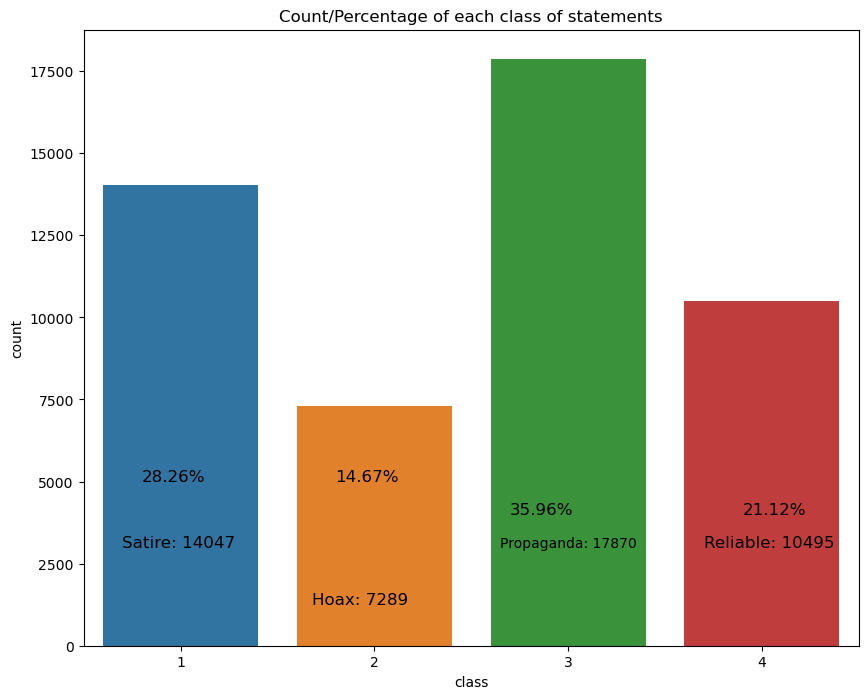

In [67]:
satire_statements = new_df.loc[new_df['class'] == 1]
hoax_statements = new_df.loc[new_df['class'] == 2]
propaganda_statements = new_df.loc[new_df['class'] == 3]
reliable_statements = new_df.loc[new_df['class'] == 4]


# Percentage of each class
satire_percent = round(len(satire_statements)/len(new_df)*100,2)
hoax_percent = round(len(hoax_statements)/len(new_df)*100,2)
propaganda_percent = round(len(propaganda_statements)/len(new_df)*100,2)
reliable_percent = round(len(reliable_statements)/len(new_df)*100,2)




fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(x='class', data=new_df)
plt.annotate(f'Satire: {len(satire_statements)}', 
             xy=(-0.3, 3000), # xy = (x dist from 0, y dist from 0)
            size=12)

plt.annotate(f'Hoax: {len(hoax_statements)}', 
             xy=(0.68, 1250), # xy = (x dist from 0, y dist from 0)
            size=12)
plt.annotate(f'Propaganda: {len(propaganda_statements)}', 
             xy=(1.65, 3000), # xy = (x dist from 0, y dist from 0)
            size=10)
plt.annotate(f'Reliable: {len(reliable_statements)}', 
             xy=(2.7, 3000), # xy = (x dist from 0, y dist from 0)
            size=12)



plt.annotate(f'{satire_percent}%', xy=(-0.2, 5000),size=12)
plt.annotate(f'{hoax_percent}%', xy=(0.8, 5000),size=12)
plt.annotate(f'{propaganda_percent}%', xy=(1.7, 4000),size=12)
plt.annotate(f'{reliable_percent}%', xy=(2.9, 4000),size=12)


ax.set_title('Count/Percentage of each class of statements')

## From the countplot above, we have managed to augment additional data samples for hoax and reliable data class, in an attempt to handle class imbalance. Let us check how our f1 score has improved.

# Do preprocessing, removal of stopwords & punctuations, and add sentiment and subjectivity to the new dataset with augmented data samples from round-trip translation

In [72]:
new_df4 = new_df.copy()

new_df4 = lemmatizePOS_and_remove_stopwords_and_punctuations_add_subjectivity_sentiment(new_df4, 'text')

In [74]:
test_df4 = test_df3.copy()

In [75]:
# training data after preprocessing
X_train_full4 = new_df4['text']
y_train_full4 = new_df4['class']

# test data after preprocessing
y_ground_truth4 = test_df4['class']
X_test_full4 = test_df4['text']


# tfidf transform
X_train_tfidf_full = tfidfvec.fit_transform(X_train_full4)
X_test_tfidf_full = tfidfvec.transform(X_test_full4)

# countvec transform
X_train_countvec_full = countvec.fit_transform(X_train_full4)
X_test_countvec_full = countvec.transform(X_test_full4)

In [80]:
# training & test data from tfidf
X_tfidf_df = pd.DataFrame(X_train_tfidf_full.toarray())
X_test_tfidf_df = pd.DataFrame(X_test_tfidf_full.toarray())

# training & test data from countvec
X_countvec_df = pd.DataFrame(X_train_countvec_full.toarray())
X_test_countvec_df = pd.DataFrame(X_test_countvec_full.toarray())


# noramlize sentiment and subjectivity scores from data
scaler = MinMaxScaler()
normalized_scores = scaler.fit_transform(new_df4[['sentiment', 'subjectivity']])
normalized_scores_df = pd.DataFrame(normalized_scores, columns=['sentiment', 'subjectivity'])

normalized_scores_test = scaler.transform(test_df4[['sentiment', 'subjectivity']])
normalized_scores_test_df = pd.DataFrame(normalized_scores_test, columns=['sentiment','subjectivity'])

# Concatenate the DataFrames with subjectivity and sentiment data
X_combined_tfidf = pd.concat([X_tfidf_df, normalized_scores_df], axis=1) # tfidf combined
X_combined_countvec = pd.concat([X_countvec_df, normalized_scores_df], axis=1) # countvec combined

X_combined_test_tfidf = pd.concat([X_test_tfidf_df, normalized_scores_test_df], axis=1) # tfidf combined
X_combined_test_countvec = pd.concat([X_test_countvec_df, normalized_scores_test_df], axis=1) # countvec combined

# NB tfidf + subjectivity + sentiment + augmented samples from round-trip translation

C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Test F1-score: 0.679
Test precision: 0.679
              precision    recall  f1-score   support

           1       0.61      0.62      0.62       750
           2       0.66      0.50      0.57       750
           3       0.62      0.89      0.73       750
           4       0.89      0.70      0.78       750

    accuracy                           0.68      3000
   macro avg       0.70      0.68      0.68      3000
weighted avg       0.70      0.68      0.68      3000



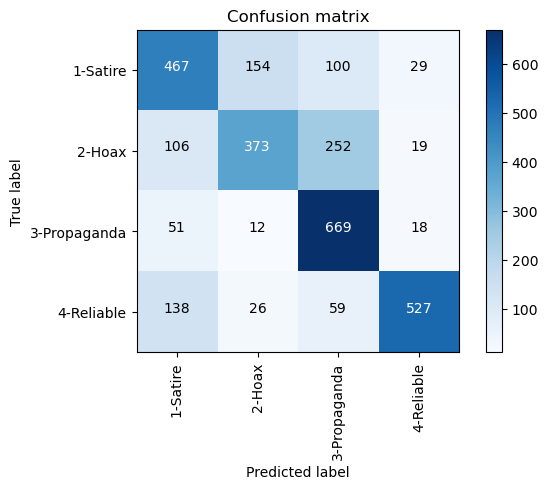

In [81]:
# fit mnb model
mnb_full = MultinomialNB().fit(X_combined_tfidf, y_train_full4)

# score our model using our pre-defined function based on f1 and precision.
mnb_base_dict4_full = score_model(mnb_full, (X_combined_tfidf,X_combined_test_tfidf,y_train_full4,y_ground_truth4))


# NB countvec + subjectivity + sentiment + augmented samples from round-trip translation

C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Test F1-score: 0.708
Test precision: 0.708
              precision    recall  f1-score   support

           1       0.65      0.56      0.60       750
           2       0.63      0.62      0.62       750
           3       0.70      0.87      0.77       750
           4       0.86      0.79      0.82       750

    accuracy                           0.71      3000
   macro avg       0.71      0.71      0.70      3000
weighted avg       0.71      0.71      0.70      3000



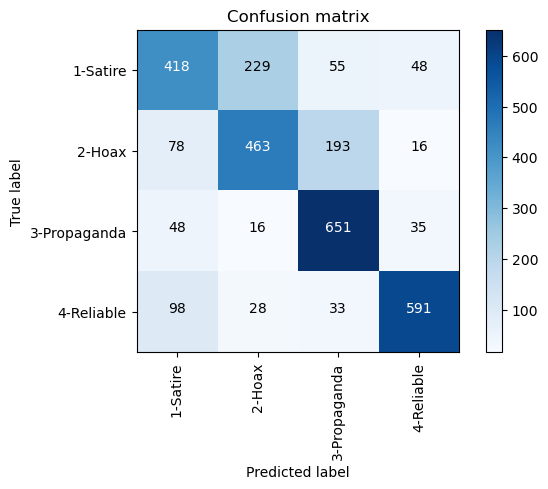

In [82]:
# fit mnb model
mnb_full = MultinomialNB().fit(X_combined_countvec, y_train_full4)

# score our model using our pre-defined function based on f1 and precision.
mnb_base_dict4_full = score_model(mnb_full, (X_combined_countvec,X_combined_test_countvec,y_train_full4,y_ground_truth4))


# LR tfidf + subjectivity + sentiment + augmented samples from round-trip translation

C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Test F1-score: 0.736
Test precision: 0.736
              precision    recall  f1-score   support

           1       0.83      0.77      0.80       750
           2       0.78      0.43      0.55       750
           3       0.61      0.84      0.71       750
           4       0.79      0.90      0.84       750

    accuracy                           0.74      3000
   macro avg       0.75      0.74      0.73      3000
weighted avg       0.75      0.74      0.73      3000



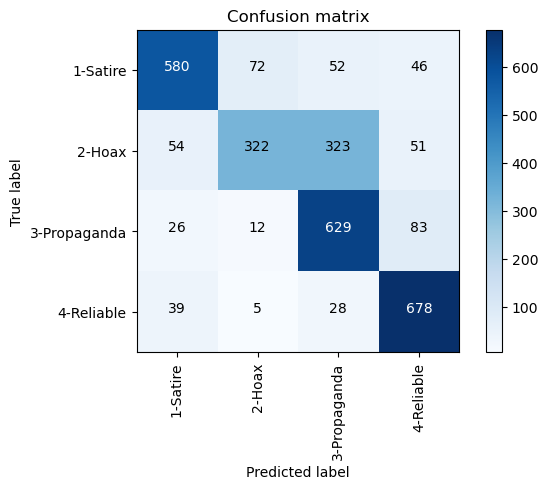

In [83]:
# fit LR model
LR_full = LogisticRegression(solver='saga').fit(X_combined_tfidf, y_train_full4)

# score our model using our pre-defined function based on f1 and precision.
LR_base_dict4_full = score_model(LR_full, (X_combined_tfidf,X_combined_test_tfidf,y_train_full4,y_ground_truth4))


# LR countvec + subjectivity + sentiment + augmented samples from round-trip translation

C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Test F1-score: 0.636
Test precision: 0.636
              precision    recall  f1-score   support

           1       0.63      0.72      0.67       750
           2       0.73      0.18      0.29       750
           3       0.55      0.89      0.68       750
           4       0.76      0.74      0.75       750

    accuracy                           0.64      3000
   macro avg       0.67      0.64      0.60      3000
weighted avg       0.67      0.64      0.60      3000



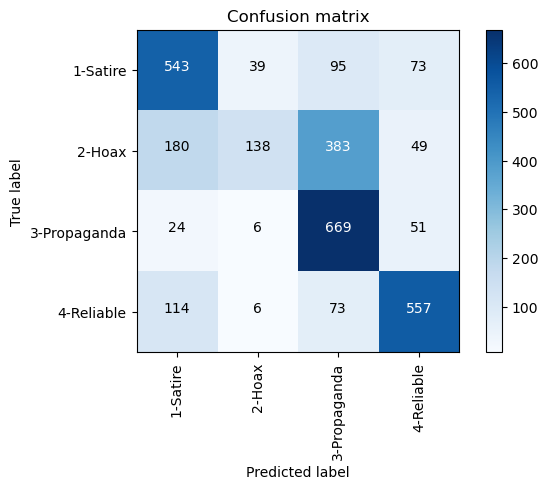

In [84]:
# fit LR model
LR_full = LogisticRegression(solver='saga').fit(X_combined_countvec, y_train_full4)

# score our model using our pre-defined function based on f1 and precision.
LR_base_dict4_full = score_model(LR_full, (X_combined_countvec,X_combined_test_countvec,y_train_full4,y_ground_truth4))


# SVC tfidf + subjectivity + sentiment + augmented samples from round-trip translation

C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Test F1-score: 0.740
Test precision: 0.740
              precision    recall  f1-score   support

           1       0.82      0.78      0.80       750
           2       0.79      0.45      0.57       750
           3       0.64      0.82      0.72       750
           4       0.76      0.91      0.83       750

    accuracy                           0.74      3000
   macro avg       0.75      0.74      0.73      3000
weighted avg       0.75      0.74      0.73      3000



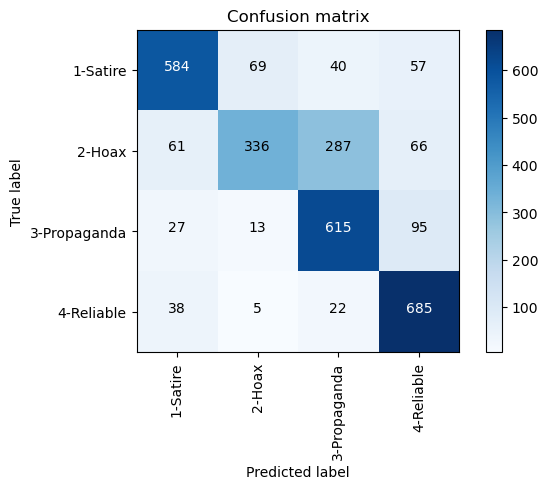

In [85]:
# fit SVC model
SVC_full = SGDClassifier(loss='hinge', random_state=randomseed).fit(X_combined_tfidf, y_train_full4)

# score our model using our pre-defined function based on f1 and precision.
SVC_base_dict4_full = score_model(SVC_full, (X_combined_tfidf,X_combined_test_tfidf,y_train_full4,y_ground_truth4))


# SVC countvec + subjectivity + sentiment + augmented samples from round-trip translation

C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Test F1-score: 0.684
Test precision: 0.684
              precision    recall  f1-score   support

           1       0.80      0.65      0.72       750
           2       0.69      0.44      0.53       750
           3       0.56      0.72      0.63       750
           4       0.73      0.93      0.82       750

    accuracy                           0.68      3000
   macro avg       0.69      0.68      0.68      3000
weighted avg       0.69      0.68      0.68      3000



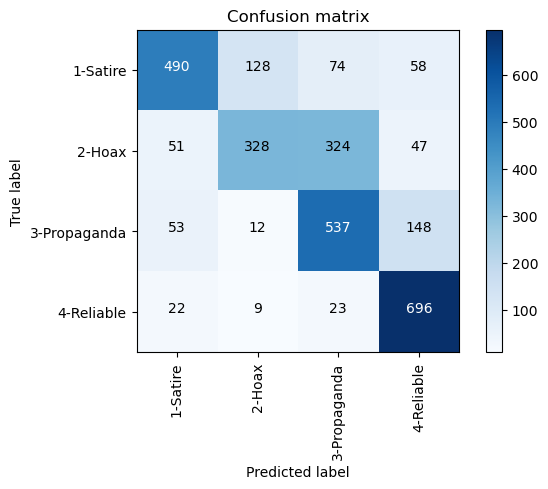

In [86]:
# fit SVC model
SVC_full = SGDClassifier(loss='hinge', random_state=randomseed).fit(X_combined_countvec, y_train_full4)

# score our model using our pre-defined function based on f1 and precision.
SVC_base_dict4_full = score_model(SVC_full, (X_combined_countvec,X_combined_test_countvec,y_train_full4,y_ground_truth4))


# Summary of results for balancedtest.csv after removing duplicates/stopwords/punctuations/lemmatization w/POS tags and feature engineering w/ subjectivity + sentiment + data augmentation samples from round-trip translation

We observed improvements in performances across the board when the new features are added together with baseline tfidf and countvec features as shown below:
- NB tfidf - 0.679
- NB countvec - 0.708
- LR tfidf - 0.736
- LR countvec - 0.636
- SVC tfidf - 0.740
- SVC countvec - 0.684


## We can see that the score of the best model dropped from 0.748 to 0.740 for f1_score 'micro'. Hence, we can safely say that the newly augmented data samples from round-trip translation did not aid as well.

Loss of meaning during translation: When translating a text from one language to another and then back to the original language, the meaning of the text can sometimes be lost or altered. This can introduce noise into your augmented dataset, which can negatively impact the model's performance.

Inaccurate translations: The quality of the translations themselves may be poor, especially if the translations are done using an automated tool. This can also introduce noise and confusion, leading to a decrease in f1-score.

Domain-specific language: If your dataset contains domain-specific language or terminology, it might not be well-handled by the translation model, resulting in inaccurate or unclear translations.

Imbalanced classes: If the newly augmented samples are not balanced well with the existing samples, the model might still have difficulty learning the distinctions between the classes, leading to poorer performance.

Overfitting: The addition of the new samples might lead to overfitting, especially if the augmented samples are very similar to the original samples or if they introduce a specific bias.

## Possible extension and future fixes for data augmentation to improve f1 score instead of decrease it:

Use a better translation model or fine-tune it on your specific domain to improve translation quality.

Manually review a subset of the translated samples to ensure the quality of the translations.

Use other data augmentation techniques such as synonym replacement, sentence rephrasing, or text mixing to augment your dataset without relying solely on round-trip translation.


# Hyperparameter tuning for simple baseline models - LR / SVC tfidf

- Since the scores for LR and SVC were the best using TfidfVectorizer and new features added like subjectivity and sentiment at 0.747 and 0.748 respectively, we will perform hyperparameter tuning for these 2 specific models to see if we can get a model with lower validation error and hence generalize to a lower test f1 score.

## get our final dataset that does not include the augmented samples, since the scores were worse off

In [94]:
# training data after preprocessing
X_train_full3 = new_df3['text']
y_train_full3 = new_df3['class']

# test data after preprocessing
y_ground_truth3 = test_df3['class']
X_test_full3 = test_df3['text']


In [95]:
# tfidf transform
X_train_tfidf_full = tfidfvec.fit_transform(X_train_full3)
X_test_tfidf_full = tfidfvec.transform(X_test_full3)

# countvec transform
X_train_countvec_full = countvec.fit_transform(X_train_full3)
X_test_countvec_full = countvec.transform(X_test_full3)


# training & test data from tfidf
X_tfidf_df = pd.DataFrame(X_train_tfidf_full.toarray())
X_test_tfidf_df = pd.DataFrame(X_test_tfidf_full.toarray())

# training & test data from countvec
X_countvec_df = pd.DataFrame(X_train_countvec_full.toarray())
X_test_countvec_df = pd.DataFrame(X_test_countvec_full.toarray())


# noramlize sentiment and subjectivity scores from data
scaler = MinMaxScaler()
normalized_scores = scaler.fit_transform(new_df3[['sentiment', 'subjectivity']])
normalized_scores_df = pd.DataFrame(normalized_scores, columns=['sentiment', 'subjectivity'])

normalized_scores_test = scaler.transform(test_df3[['sentiment', 'subjectivity']])
normalized_scores_test_df = pd.DataFrame(normalized_scores_test, columns=['sentiment','subjectivity'])

# Concatenate the DataFrames with subjectivity and sentiment data
X_combined_tfidf = pd.concat([X_tfidf_df, normalized_scores_df], axis=1) # tfidf combined
X_combined_countvec = pd.concat([X_countvec_df, normalized_scores_df], axis=1) # countvec combined

X_combined_test_tfidf = pd.concat([X_test_tfidf_df, normalized_scores_test_df], axis=1) # tfidf combined
X_combined_test_countvec = pd.concat([X_test_countvec_df, normalized_scores_test_df], axis=1) # countvec combined


# train test split with 15% validation data for X_combined_tfidf

In [98]:
X_combined_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,9992,9993,9994,9995,9996,9997,9998,9999,sentiment,subjectivity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.583625,0.579000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.625379,0.538636
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.059418,0.0,0.540038,0.412470
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.559092,0.404162
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.597459,0.593101


In [99]:
# # Do a train test split with 15% validation split
# X_train, X_test, y_train, y_test = train_test_split(X_combined_tfidf, y_train_full3, test_size=0.15, random_state=randomseed)

# # Store the full data into a tuple form so that we are able to easily pass them into the print_results() function
# # that was defined above.
# full_data = (X_train, X_test, y_train, y_test)


In [114]:
# convert X_combined_tfidf into a sparse matrix to save memory for hyperparameter tuning.

X_combined_tfidf_sparse = csr_matrix(X_combined_tfidf.values)

In [115]:
# Do a train test split with 15% validation split
X_train, X_test, y_train, y_test = train_test_split(X_combined_tfidf_sparse, y_train_full3, test_size=0.15, random_state=randomseed)

# Store the full data into a tuple form so that we are able to easily pass them into the print_results() function
# that was defined above.
full_data = (X_train, X_test, y_train, y_test)


In [113]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
from scipy.sparse import csr_matrix

In [100]:
# Define f1 scorer to be passed into GridSearchCV
f1scorer = make_scorer(f1_score, average='micro') # use average = 'micro' for f1-score.

In [101]:
result_df = pd.DataFrame(columns=['Model', 'Best Params', 'Test F1-Score (micro)'])
result_df

# Create a dictionary to store training results and store best parametes for each trained model out of the 3.
resultdict = {}

In [102]:
result_df

,Model,Best Params,Test F1-Score (micro)


# Define a function for pipline using GridSearchCV

In [125]:
# Define a function for training a model - use f1scorer as the scorer within the pipeline
def train_model(Xtrain, ytrain, user_pipeline, user_paramgrid, scorer):
    """
    This function takes in training dataset for X and y, user-defined pipeline, user-defined parameter grid for each specific model,
    file name and scorer function and returns the trained model.
    """
    model = GridSearchCV(estimator=user_pipeline, param_grid=user_paramgrid, scoring=scorer, cv=5, n_jobs=-1, verbose=2, error_score='raise')
    model.fit(Xtrain, ytrain)
    return model

# Function to display metrics of learned model
def print_results(model, traintestdata, description):
    """
    Takes in a trained/learned model, tuple containing X and y train&test data, and description
    Prints the relevant scoring results from cross validation. Adds the best parameters to the result dictionary for tracking.
    """
    print(f'Best parameters: {model.best_params_}')
    # Tuple Unpacking for xtrain, xtest, ytrain, ytest from input
    xtrain,xtest,ytrain,ytest = traintestdata
    # Model prediction on train/test data
    ytestpred = model.predict(xtest)
    # ytestprobability = model.predict_proba(xtest)[:,1]
    ytrainpred = model.predict(xtrain)
    # Model Scoring
    test_f1score = f1_score(ytest, ytestpred, average='micro') # use micro for multiclass imbalanced classification
    train_f1score = f1_score(ytrain,ytrainpred, average='micro') # use micro for multiclass imbalanced classification

    # Plot x (cross validation results) against y (scoring metrics)
    fig,ax = plt.subplots(figsize = (15,5))
    cvrank = sorted([[k,v] for k,v in zip(model.cv_results_['params'], model.cv_results_['mean_test_score'])],key = lambda x: x[1])
    plt.plot([str(i[0]) for i in cvrank],[i[1] for i in cvrank])
    plt.tick_params(axis='x', rotation=90)
    plt.ylabel('F1 Score')
    plt.xlabel('Cross Validation Params')
    plt.show()
    # Print out results
    print(f'F1_score Best CV Score: {max(model.cv_results_["mean_test_score"])}')
    print(f'f1_score (Train): {train_f1score:.3f}')
    print(f'f1_score (Test): {test_f1score:.3f}')

    print(confusion_matrix(ytest, ytestpred))
    print(classification_report(ytest, ytestpred))
    # Update result dictionary for tracking.
#     resultdict[description] = [model.best_params_, test_f1score]
    result_to_save_df = pd.DataFrame({
        'Model': description,
        'Best Params': model.best_params_,
        'Test F1-Score (micro)': test_f1score
    })
    
    # append results to our collated result_df global variable
    global result_df
    result_df = result_df.append(result_to_save_df)
    
    global resultdict
    resultdict[description] = [model.best_params_, test_f1score]

# Define our pipeline for LR tfidf

In [128]:
pipe_lr_tfidf = Pipeline([
    ('lr', LogisticRegression(random_state=randomseed, solver='saga'))
])

# parameters for hyperparameter tuning
lr_tfidf_param = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10],
    'lr__penalty': ['l1','l2']
}

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'lr__C': 10, 'lr__penalty': 'l2'}


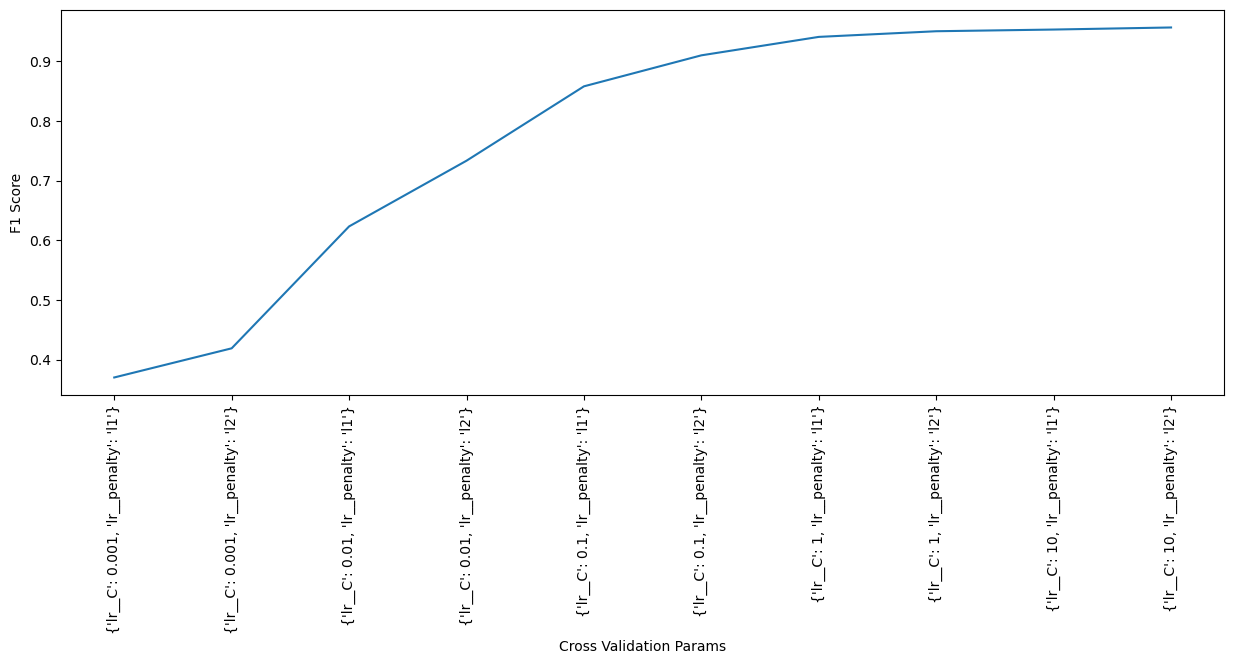

F1_score Best CV Score: 0.9570032705580914
f1_score (Train): 0.999
f1_score (Test): 0.963
[[2073   10   34   36]
 [  11 1038   18    1]
 [  26   15 2515    9]
 [  64    7   36 1405]]
              precision    recall  f1-score   support

           1       0.95      0.96      0.96      2153
           2       0.97      0.97      0.97      1068
           3       0.97      0.98      0.97      2565
           4       0.97      0.93      0.95      1512

    accuracy                           0.96      7298
   macro avg       0.96      0.96      0.96      7298
weighted avg       0.96      0.96      0.96      7298



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_21484\1794041835.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_to_save_df)


In [129]:
# Train model using the train_model function
lr_tfidf = train_model(X_train, y_train, pipe_lr_tfidf, lr_tfidf_param, f1scorer)

print_results(lr_tfidf, full_data, 'Logistic Regression (tfidf)')

# Define our pipeline for SVC tfidf

In [122]:
pipe_svc_tfidf = Pipeline([
    ('svc', SGDClassifier(random_state=randomseed, loss='hinge'))
])

# parameters for hyperparameter tuning
svc_tfidf_param = {
    'svc__alpha': [0.0001,0.001,0.01,0.1],
    'svc__penalty': ['l1','l2','elasticnet']
}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'svc__alpha': 0.0001, 'svc__penalty': 'l2'}


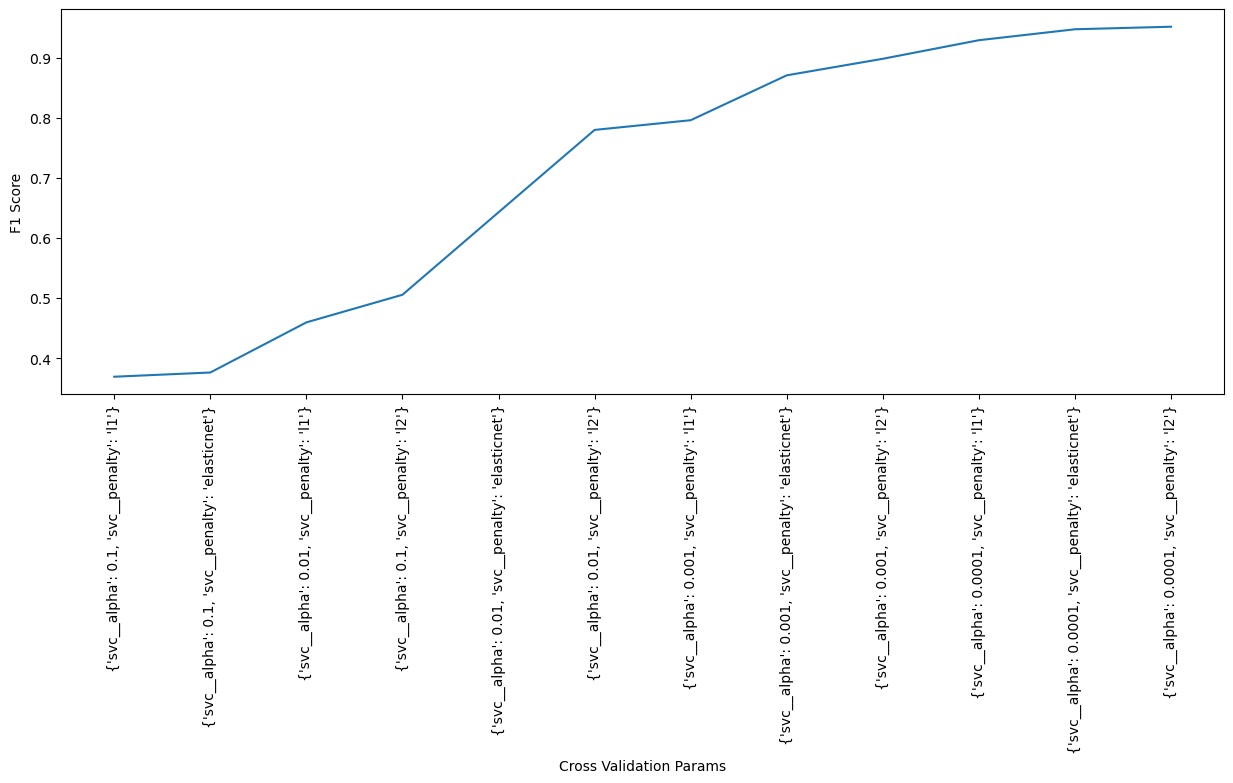

F1_score Best CV Score: 0.9518039910720825
f1_score (Train): 0.966
f1_score (Test): 0.953
[[2098    7   31   17]
 [  18 1022   25    3]
 [  39   15 2508    3]
 [ 118    5   59 1330]]
              precision    recall  f1-score   support

           1       0.92      0.97      0.95      2153
           2       0.97      0.96      0.97      1068
           3       0.96      0.98      0.97      2565
           4       0.98      0.88      0.93      1512

    accuracy                           0.95      7298
   macro avg       0.96      0.95      0.95      7298
weighted avg       0.95      0.95      0.95      7298



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_21484\1794041835.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_to_save_df)


In [126]:
# Train model using the train_model function
svc_tfidf = train_model(X_train, y_train, pipe_svc_tfidf, svc_tfidf_param, f1scorer)

print_results(svc_tfidf, full_data, 'SVM w/ linear kernel (tfidf)')

# View our final results

In [133]:
sortedresults = sorted([[k,v[0],v[1]] for k, v in resultdict.items()], key = lambda x: x[2], reverse = True)
res = pd.DataFrame(sortedresults, columns = ['Model','Best Params','F1 Score'])

from IPython.core.display import HTML
display(HTML(res.to_html()))

,Model,Best Params,F1 Score
0,Logistic Regression (tfidf),"{'lr__C': 10, 'lr__penalty': 'l2'}",0.963415
1,SVM w/ linear kernel (tfidf),"{'svc__alpha': 0.0001, 'svc__penalty': 'l2'}",0.953412


## From the results above, we can see the the best model on validation f1 score 'micro' was that of 0.963 as compared to SVM w/ linear kernel at 0.953. 

## The new update is that the best model now shows that the regularization constant C should be set at 10 instead of the default of 1. There is no change involved for the SVM w/ linear kernel, as they are the default settings of sklearn SGDClassifier.

- Let us see if the best model of LogisticRegression now can give us a higher score than 0.747 (LR tfidf previously) and 0.748 (SVC tfidf previously)

C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Test F1-score: 0.735
Test precision: 0.735
              precision    recall  f1-score   support

           1       0.84      0.75      0.79       750
           2       0.75      0.46      0.57       750
           3       0.60      0.81      0.69       750
           4       0.80      0.92      0.86       750

    accuracy                           0.73      3000
   macro avg       0.75      0.73      0.73      3000
weighted avg       0.75      0.73      0.73      3000



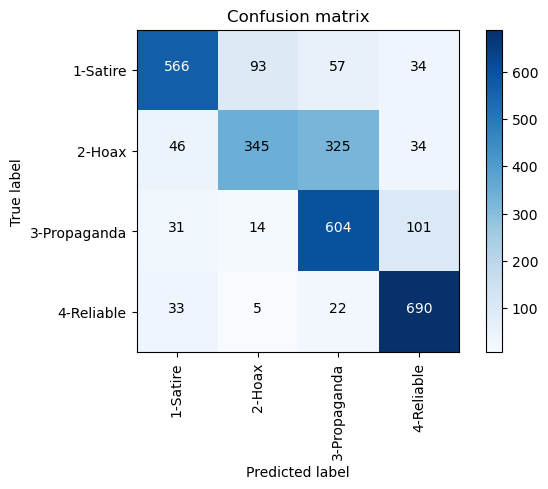

In [135]:
# fit LR model
LR_full_final = LogisticRegression(solver='saga', C=10, random_state=randomseed).fit(X_combined_tfidf_sparse, y_train_full3)

# score our model using our pre-defined function based on f1 and precision.
LR_base_dict_final = score_model(LR_full_final, (X_combined_tfidf_sparse,X_combined_test_tfidf,y_train_full3,y_ground_truth3))


C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Test F1-score: 0.748
Test precision: 0.748
              precision    recall  f1-score   support

           1       0.83      0.78      0.80       750
           2       0.79      0.46      0.58       750
           3       0.62      0.86      0.72       750
           4       0.83      0.90      0.86       750

    accuracy                           0.75      3000
   macro avg       0.76      0.75      0.74      3000
weighted avg       0.76      0.75      0.74      3000



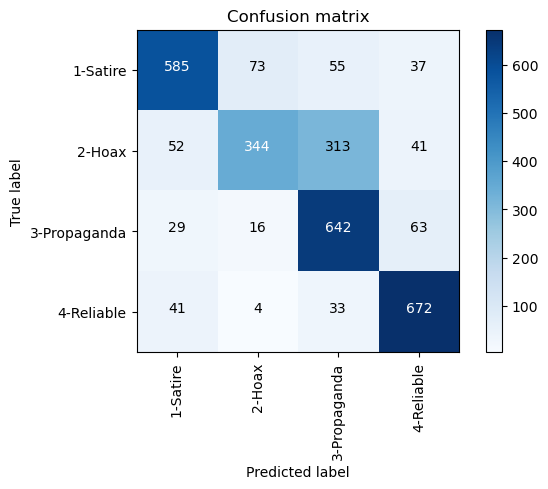

In [136]:
# fit LR model
LR_full_final = LogisticRegression(solver='saga', C=1, random_state=randomseed).fit(X_combined_tfidf_sparse, y_train_full3)

# score our model using our pre-defined function based on f1 and precision.
LR_base_dict_final = score_model(LR_full_final, (X_combined_tfidf_sparse,X_combined_test_tfidf,y_train_full3,y_ground_truth3))


C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Test F1-score: 0.740
Test precision: 0.740
              precision    recall  f1-score   support

           1       0.82      0.75      0.79       750
           2       0.76      0.45      0.57       750
           3       0.61      0.87      0.72       750
           4       0.83      0.89      0.86       750

    accuracy                           0.74      3000
   macro avg       0.76      0.74      0.73      3000
weighted avg       0.76      0.74      0.73      3000



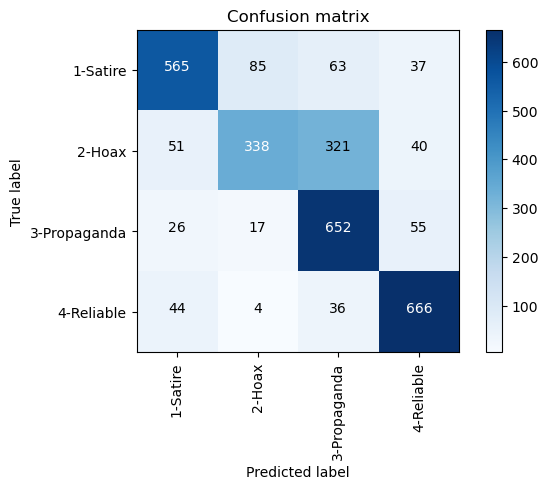

In [137]:
# fit LR model
SVC_full_final = SGDClassifier(loss='hinge', alpha=0.0001, random_state=randomseed).fit(X_combined_tfidf_sparse, y_train_full3)

# score our model using our pre-defined function based on f1 and precision.
SVC_base_dict_final = score_model(SVC_full_final, (X_combined_tfidf_sparse,X_combined_test_tfidf,y_train_full3,y_ground_truth3))


# END